In [1]:
# Exercise 2: Autoencoder with Two-dimensional Data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

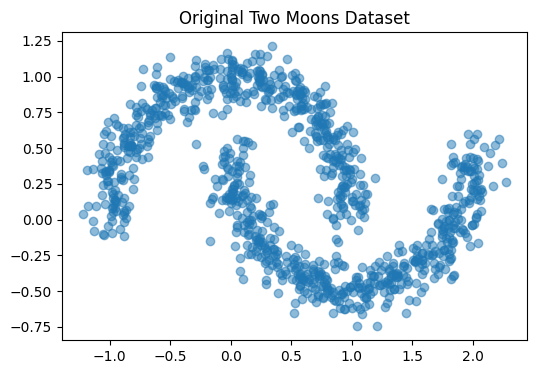

In [3]:
# Generate and plot the original moon dataset
X, _ = make_moons(n_samples=1000, noise=0.1)
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title('Original Two Moons Dataset')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import numpy as np


class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()

        # Encoder layers
        encoder_layers = []
        prev_size = input_size

        # First hidden layer
        encoder_layers.append(nn.Linear(prev_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        prev_size = hidden_size

        # Additional hidden layers
        for _ in range(layers - 1):
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            prev_size = hidden_size

        # Bottleneck layer
        encoder_layers.append(nn.Linear(prev_size, bottleneck_size))

        # Create encoder
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder layers (mirror of encoder)
        decoder_layers = []
        prev_size = bottleneck_size

        # First layer after bottleneck
        decoder_layers.append(nn.Linear(prev_size, hidden_size))
        decoder_layers.append(nn.ReLU())
        prev_size = hidden_size

        # Additional hidden layers
        for _ in range(layers - 1):
            decoder_layers.append(nn.Linear(prev_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            prev_size = hidden_size

        # Output layer
        decoder_layers.append(nn.Linear(prev_size, input_size))

        # Create decoder
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


<div style="color: green; font-weight: bold">Comment</div>
In the sample solution, an assert statement (`assert(layers >= 2)`) is included to ensure a minimum number of layers. This helps prevent issues caused by user inputs that specify an insufficient number of layers. It would be helpful to add this to your solution.


In [5]:
def train_autoencoder(model, n_samples=1000, epochs=10, lr=0.001, X_data=None, noise_level=0.1):
    # Generate moon dataset
    if X_data is None:
        X, _ = make_moons(n_samples=n_samples, noise=noise_level)
        X = torch.FloatTensor(X)
    else:
        X = X_data

    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []  # Add this line to track losses

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, X)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())  # Add this line to store loss

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, losses  # Modified to return both model and losses


In [6]:
def visualize_results(model, n_samples=1000):
    # Generate test data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    # Get reconstructions
    with torch.no_grad():
        reconstructed = model(X)
    
    # Convert to numpy for plotting
    X = X.numpy()
    reconstructed = reconstructed.numpy()
    
    # Plot original vs reconstructed
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.title('Original Data')
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(reconstructed[:, 0], reconstructed[:, 1], c='red', alpha=0.5, label='Reconstructed')
    plt.title('Reconstructed Data')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch [10/100], Loss: 0.5949
Epoch [20/100], Loss: 0.5822
Epoch [30/100], Loss: 0.5716
Epoch [40/100], Loss: 0.5624
Epoch [50/100], Loss: 0.5537
Epoch [60/100], Loss: 0.5446
Epoch [70/100], Loss: 0.5372
Epoch [80/100], Loss: 0.5303
Epoch [90/100], Loss: 0.5233
Epoch [100/100], Loss: 0.5156


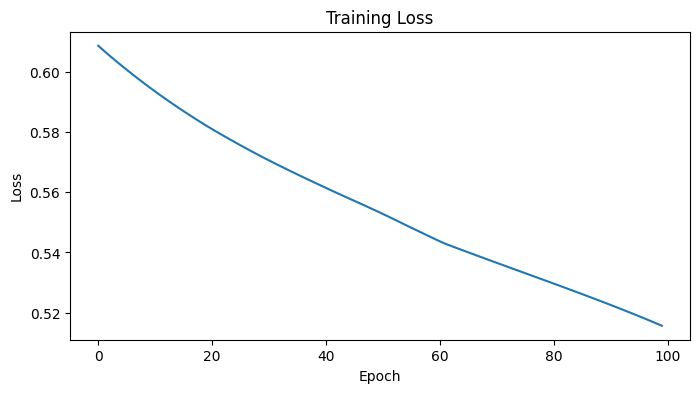

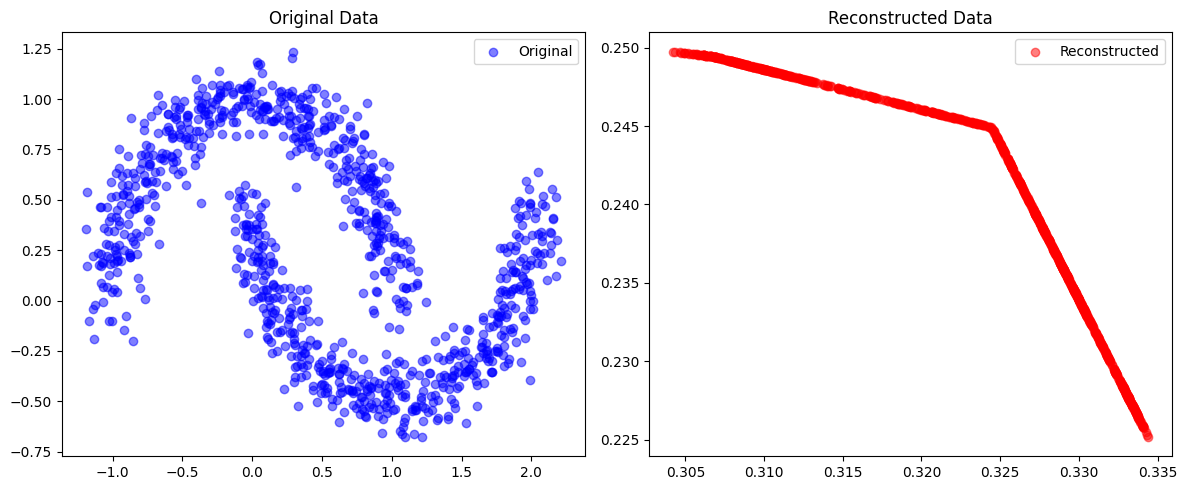

In [7]:
# Create and train the model
model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=2)
trained_model, losses = train_autoencoder(model, n_samples=1000, epochs=100, lr=0.001)

# Plot training losses
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize results
visualize_results(trained_model)

In [8]:
def test_hyperparameters():
    # Test different configurations
    hidden_sizes = [4, 8, 16, 32]
    layer_counts = [1, 2, 3, 4]
    sample_sizes = [500, 1000, 2000]
    
    results = {}
    
    # Generate consistent test data
    X_test, _ = make_moons(n_samples=500, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    for hidden_size in hidden_sizes:
        for layers in layer_counts:
            for n_samples in sample_sizes:
                key = f"h{hidden_size}_l{layers}_n{n_samples}"
                print(f"\nTesting configuration: {key}")
                
                model = Autoencoder(
                    input_size=2,
                    bottleneck_size=1,
                    hidden_size=hidden_size,
                    layers=layers
                )
                
                # Train model
                trained_model, losses = train_autoencoder(
                    model, 
                    n_samples=n_samples,
                    epochs=100,
                    lr=0.001
                )
                
                # Compute test error
                with torch.no_grad():
                    reconstructed = trained_model(X_test)
                    test_loss = nn.MSELoss()(reconstructed, X_test)
                
                results[key] = {
                    'test_loss': test_loss.item(),
                    'training_losses': losses,
                    'model': trained_model,
                    'params': {
                        'hidden_size': hidden_size,
                        'layers': layers,
                        'n_samples': n_samples
                    }
                }
    
    return results

In [9]:
def plot_hyperparameter_comparison(results):
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Hyperparameter Analysis', fontsize=16)
    
    # Extract data
    configs = list(results.keys())
    hidden_sizes = sorted(list(set([results[k]['params']['hidden_size'] for k in configs])))
    layer_counts = sorted(list(set([results[k]['params']['layers'] for k in configs])))
    
    # Plot 1: Hidden Size vs Test Loss
    ax = axes[0, 0]
    for layers in layer_counts:
        losses = [results[k]['test_loss'] for k in configs 
                 if results[k]['params']['layers'] == layers 
                 and results[k]['params']['n_samples'] == 1000]
        ax.plot(hidden_sizes, losses, 'o-', label=f'{layers} layers')
    
    ax.set_xlabel('Hidden Layer Size')
    ax.set_ylabel('Test Loss')
    ax.set_title('Effect of Hidden Layer Size')
    ax.legend()
    ax.grid(True)
    
    # Plot 2: Number of Layers vs Test Loss
    ax = axes[0, 1]
    for hidden_size in hidden_sizes:
        losses = [results[k]['test_loss'] for k in configs 
                 if results[k]['params']['hidden_size'] == hidden_size 
                 and results[k]['params']['n_samples'] == 1000]
        ax.plot(layer_counts, losses, 'o-', label=f'size {hidden_size}')
    
    ax.set_xlabel('Number of Layers')
    ax.set_ylabel('Test Loss')
    ax.set_title('Effect of Layer Count')
    ax.legend()
    ax.grid(True)
    
    # Plot 3: Training Curves for Best Configs
    ax = axes[1, 0]
    best_configs = sorted(configs, key=lambda k: results[k]['test_loss'])[:3]
    for config in best_configs:
        ax.plot(results[config]['training_losses'], 
                label=f"h{results[config]['params']['hidden_size']}_l{results[config]['params']['layers']}")
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Curves (Best Configurations)')
    ax.legend()
    ax.grid(True)
    
    # Plot 4: Best vs Worst Reconstruction
    ax = axes[1, 1]
    best_config = min(configs, key=lambda k: results[k]['test_loss'])
    worst_config = max(configs, key=lambda k: results[k]['test_loss'])
    
    X_test, _ = make_moons(n_samples=200, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    with torch.no_grad():
        best_reconst = results[best_config]['model'](X_test).numpy()
        worst_reconst = results[worst_config]['model'](X_test).numpy()
    
    X_test = X_test.numpy()
    
    ax.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.3, label='Original')
    ax.scatter(best_reconst[:, 0], best_reconst[:, 1], c='green', alpha=0.3, label='Best')
    ax.scatter(worst_reconst[:, 0], worst_reconst[:, 1], c='red', alpha=0.3, label='Worst')
    ax.set_title('Reconstruction Comparison')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Run hyperparameter testing
print("Starting hyperparameter analysis...")
results = test_hyperparameters()


Starting hyperparameter analysis...

Testing configuration: h4_l1_n500
Epoch [10/100], Loss: 1.3314
Epoch [20/100], Loss: 1.2673
Epoch [30/100], Loss: 1.2109
Epoch [40/100], Loss: 1.1582
Epoch [50/100], Loss: 1.1083
Epoch [60/100], Loss: 1.0606
Epoch [70/100], Loss: 1.0150
Epoch [80/100], Loss: 0.9718
Epoch [90/100], Loss: 0.9308
Epoch [100/100], Loss: 0.8917

Testing configuration: h4_l1_n1000
Epoch [10/100], Loss: 0.8378
Epoch [20/100], Loss: 0.8167
Epoch [30/100], Loss: 0.7966
Epoch [40/100], Loss: 0.7774
Epoch [50/100], Loss: 0.7592
Epoch [60/100], Loss: 0.7419
Epoch [70/100], Loss: 0.7257
Epoch [80/100], Loss: 0.7103
Epoch [90/100], Loss: 0.6958
Epoch [100/100], Loss: 0.6822

Testing configuration: h4_l1_n2000
Epoch [10/100], Loss: 0.5092
Epoch [20/100], Loss: 0.5087
Epoch [30/100], Loss: 0.5084
Epoch [40/100], Loss: 0.5081
Epoch [50/100], Loss: 0.5076
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5061
Epoch [80/100], Loss: 0.5049
Epoch [90/100], Loss: 0.5034
Epoch [100/100


Generating visualization...


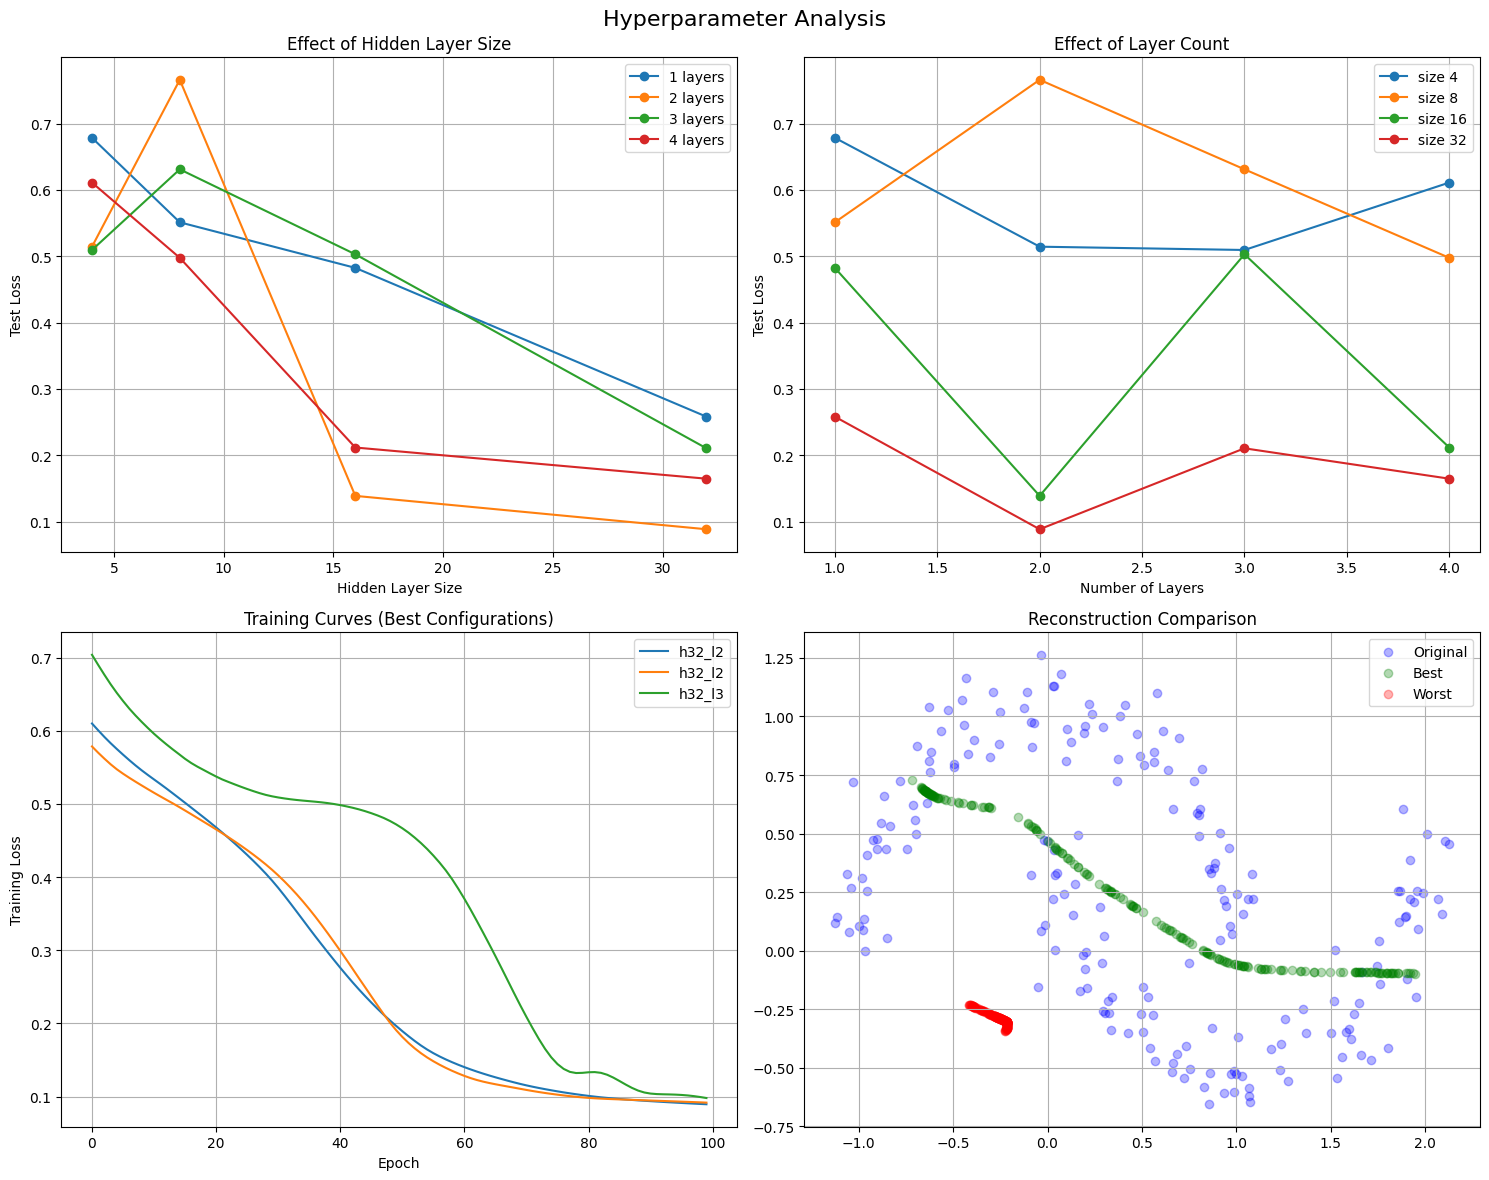

In [11]:
# Plot results
print("\nGenerating visualization...")
plot_hyperparameter_comparison(results)


In [12]:
# Print summary statistics
print("\nSummary of Results:")
configs = list(results.keys())
best_config = min(configs, key=lambda k: results[k]['test_loss'])
worst_config = max(configs, key=lambda k: results[k]['test_loss'])

print(f"\nBest configuration:")
print(f"- Hidden size: {results[best_config]['params']['hidden_size']}")
print(f"- Layers: {results[best_config]['params']['layers']}")
print(f"- Samples: {results[best_config]['params']['n_samples']}")
print(f"- Test Loss: {results[best_config]['test_loss']:.6f}")

print(f"\nWorst configuration:")
print(f"- Hidden size: {results[worst_config]['params']['hidden_size']}")
print(f"- Layers: {results[worst_config]['params']['layers']}")
print(f"- Samples: {results[worst_config]['params']['n_samples']}")
print(f"- Test Loss: {results[worst_config]['test_loss']:.6f}")


Summary of Results:

Best configuration:
- Hidden size: 32
- Layers: 2
- Samples: 1000
- Test Loss: 0.088318

Worst configuration:
- Hidden size: 4
- Layers: 1
- Samples: 500
- Test Loss: 0.899735


<div style="color: green; font-weight: bold">Comment</div>
Really good implementation and showing what are the best and worst layers

# Exercise_1.2

In [13]:
def investigate_reproducibility(n_runs=5):
    # Best hyperparameters based on previous results
    best_params = {
        'input_size': 2,
        'bottleneck_size': 1,
        'hidden_size': 32,
        'layers': 2  # Updated based on your results
    }
    
    same_data_results = []
    diff_data_results = []
    
    # Generate fixed dataset
    X_fixed, _ = make_moons(n_samples=2000, noise=0.1)
    X_fixed = torch.FloatTensor(X_fixed)
    
    # Test data
    X_test, _ = make_moons(n_samples=500, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    print("Training models with same dataset:")
    for i in range(n_runs):
        torch.manual_seed(i)  # Set seed for reproducibility
        model = Autoencoder(**best_params)
        trained_model, _ = train_autoencoder(model, X_data=X_fixed, epochs=100, lr=0.001)
        
        with torch.no_grad():
            reconstructed = trained_model(X_test)
            test_loss = nn.MSELoss()(reconstructed, X_test)
            same_data_results.append({
                'test_loss': test_loss.item(),
                'reconstruction': reconstructed.numpy()
            })
    
    print("\nTraining models with different datasets:")
    for i in range(n_runs):
        torch.manual_seed(i)
        model = Autoencoder(**best_params)
        trained_model, _ = train_autoencoder(model, n_samples=2000, epochs=100, lr=0.001)
        
        with torch.no_grad():
            reconstructed = trained_model(X_test)
            test_loss = nn.MSELoss()(reconstructed, X_test)
            diff_data_results.append({
                'test_loss': test_loss.item(),
                'reconstruction': reconstructed.numpy()
            })
    
    return same_data_results, diff_data_results, X_test.numpy()

In [14]:
def plot_reproducibility_results(same_data_results, diff_data_results, X_test_np):
    plt.figure(figsize=(15, 6))
    
    # Plot overlapped reconstructions for the same data
    plt.subplot(121)
    plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c='blue', alpha=0.5, label='Original')
    for result in same_data_results:
        recon = result['reconstruction']
        plt.scatter(recon[:, 0], recon[:, 1], alpha=0.1)
    plt.title('Reconstructions (Same Training Data)')
    plt.legend()
    
    # Plot overlapped reconstructions for the different data
    plt.subplot(122)
    plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c='blue', alpha=0.5, label='Original')
    for result in diff_data_results:
        recon = result['reconstruction']
        plt.scatter(recon[:, 0], recon[:, 1], alpha=0.1)
    plt.title('Reconstructions (Different Training Data)')
    plt.legend()
    
    # Stats
    same_losses = [r['test_loss'] for r in same_data_results]
    diff_losses = [r['test_loss'] for r in diff_data_results]
    print("\nStatistics:")
    print(f"Same Data - Mean Loss: {np.mean(same_losses):.6f}, Std Loss: {np.std(same_losses):.6f}")
    print(f"Different Data - Mean Loss: {np.mean(diff_losses):.6f}, Std Loss: {np.std(diff_losses):.6f}")
    
    plt.tight_layout()
    plt.show()

    # Stats
    print(f"""
    Same Data Statistics:
    Mean Loss: {np.mean(same_losses):.6f}
    Std Loss: {np.std(same_losses):.6f}
    
    Different Data Statistics:
    Mean Loss: {np.mean(diff_losses):.6f}
    Std Loss: {np.std(diff_losses):.6f}
    """)



Training models with same dataset:
Epoch [10/100], Loss: 0.6043
Epoch [20/100], Loss: 0.5162
Epoch [30/100], Loss: 0.4289
Epoch [40/100], Loss: 0.3260
Epoch [50/100], Loss: 0.2057
Epoch [60/100], Loss: 0.1221
Epoch [70/100], Loss: 0.1059
Epoch [80/100], Loss: 0.1012
Epoch [90/100], Loss: 0.0973
Epoch [100/100], Loss: 0.0932
Epoch [10/100], Loss: 0.7422
Epoch [20/100], Loss: 0.6605
Epoch [30/100], Loss: 0.5481
Epoch [40/100], Loss: 0.4210
Epoch [50/100], Loss: 0.3426
Epoch [60/100], Loss: 0.2685
Epoch [70/100], Loss: 0.2167
Epoch [80/100], Loss: 0.1775
Epoch [90/100], Loss: 0.1417
Epoch [100/100], Loss: 0.1131
Epoch [10/100], Loss: 0.5459
Epoch [20/100], Loss: 0.4969
Epoch [30/100], Loss: 0.4525
Epoch [40/100], Loss: 0.3922
Epoch [50/100], Loss: 0.3002
Epoch [60/100], Loss: 0.2112
Epoch [70/100], Loss: 0.1639
Epoch [80/100], Loss: 0.1289
Epoch [90/100], Loss: 0.1038
Epoch [100/100], Loss: 0.0911
Epoch [10/100], Loss: 0.5217
Epoch [20/100], Loss: 0.4549
Epoch [30/100], Loss: 0.3875
Epoch

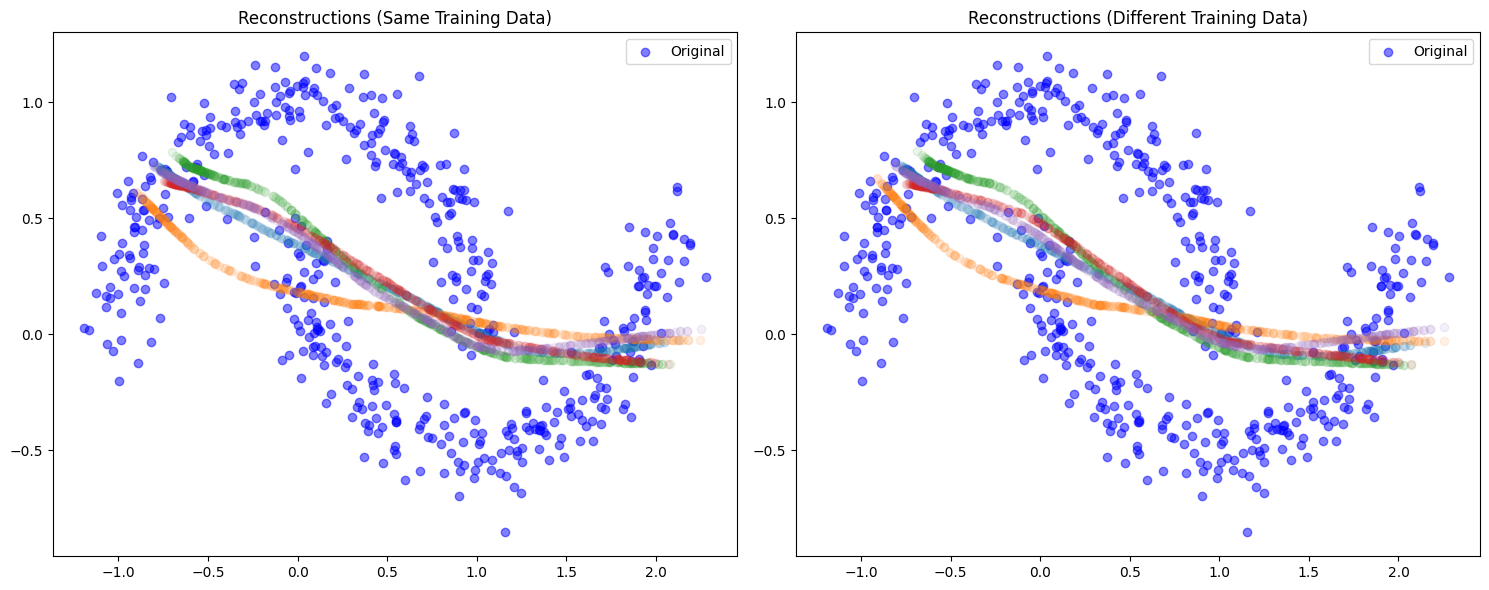


    Same Data Statistics:
    Mean Loss: 0.095279
    Std Loss: 0.007617
    
    Different Data Statistics:
    Mean Loss: 0.095077
    Std Loss: 0.006818
    


In [15]:
# Set initial seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Run analysis
same_results, diff_results, test_data = investigate_reproducibility(n_runs=5)

# Plot results
plot_reproducibility_results(same_results, diff_results, test_data)

- The difference is only about 0.0002, it shows that the model's performance is very consistent regardless of whether it's trained on the same or different datasets.

- We can say that the chosen hyperparameters (hidden_size=32, layers=3) seem to produce consistent results.

# Exercise_1.3

In [16]:
from sklearn.mixture import GaussianMixture

In [17]:
def analyze_code_distribution(model, n_samples=2000):
    # Generate data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    # Get encoded representations
    with torch.no_grad():
        codes = model.encoder(X).numpy()
    
    # Plot histogram of codes
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.hist(codes, bins=50, density=True, alpha=0.7)
    plt.title('Distribution of Codes')
    plt.xlabel('Code Value')
    plt.ylabel('Density')
    
    # Fit GMM
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(codes)
    
    # Generate synthetic data
    synthetic_codes = gmm.sample(n_samples)[0]
    synthetic_codes = torch.FloatTensor(synthetic_codes)
    
    # Decode synthetic data
    with torch.no_grad():
        synthetic_data = model.decoder(synthetic_codes).numpy()
    
    # Plot original vs synthetic data
    plt.subplot(132)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.title('Original Data')
    plt.legend()
    
    plt.subplot(133)
    plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], 
                c='red', alpha=0.5, label='Generated')
    plt.title('GMM Generated Data')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print GMM parameters
    print("\nGMM Parameters:")
    print(f"Means: {gmm.means_.flatten()}")
    print(f"Variances: {gmm.covariances_.flatten()}")
    print(f"Weights: {gmm.weights_}")

Epoch [10/100], Loss: 0.6892
Epoch [20/100], Loss: 0.6023
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.4554
Epoch [50/100], Loss: 0.4156
Epoch [60/100], Loss: 0.3395
Epoch [70/100], Loss: 0.2557
Epoch [80/100], Loss: 0.2010
Epoch [90/100], Loss: 0.1735
Epoch [100/100], Loss: 0.1493


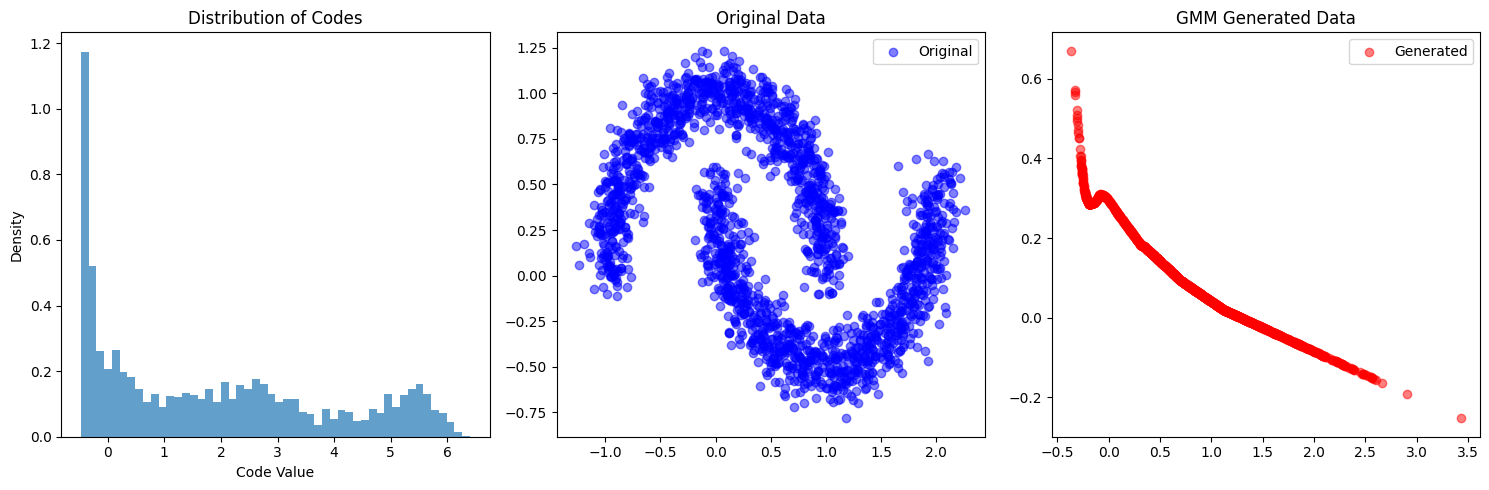


GMM Parameters:
Means: [ 2.44375917 -0.36563006]
Variances: [3.65491178e+00 3.21528964e-03]
Weights: [0.7831472 0.2168528]


In [18]:
# Use the best model from previous analysis
best_model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=3)
best_model, _ = train_autoencoder(best_model, n_samples=2000, epochs=100, lr=0.001)

# Analyze code distribution
analyze_code_distribution(best_model)

- Highly imbalanced weights (0.78 vs 0.22)
- One component dominates with 78% of the data
- This imbalance shows that the encoding might be biased towards one moon shape. And looking at the plot, we can see that this is the case


I am not sure if this a mistake from our side, but the plot does not show that the GMM has successfully reconstructed the 2 moons.

<div style="color: green; font-weight: bold">Comment</div>
As suggested there is high imbalance with the weights , Consider looking into this part of the code

# Exercise_1.4

In [19]:
def evaluate_noise_sensitivity(model, noise_levels=[0.1, 0.2], n_samples=1000):
    plt.figure(figsize=(15, 5))
    
    for idx, noise in enumerate(noise_levels, 1):
        # Generate test data with different noise level
        X_test, _ = make_moons(n_samples=n_samples, noise=noise)
        X_test = torch.FloatTensor(X_test)
        
        # Get reconstructions
        with torch.no_grad():
            reconstructed = model(X_test)
            test_loss = nn.MSELoss()(reconstructed, X_test)
        
        # Convert to numpy for plotting
        X_test = X_test.numpy()
        reconstructed = reconstructed.numpy()
        
        # Plot
        plt.subplot(1, len(noise_levels), idx)
        plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.5, label='Original')
        plt.scatter(reconstructed[:, 0], reconstructed[:, 1], c='red', alpha=0.5, label='Reconstructed')
        plt.title(f'Noise Level {noise}\nMSE Loss: {test_loss:.4f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

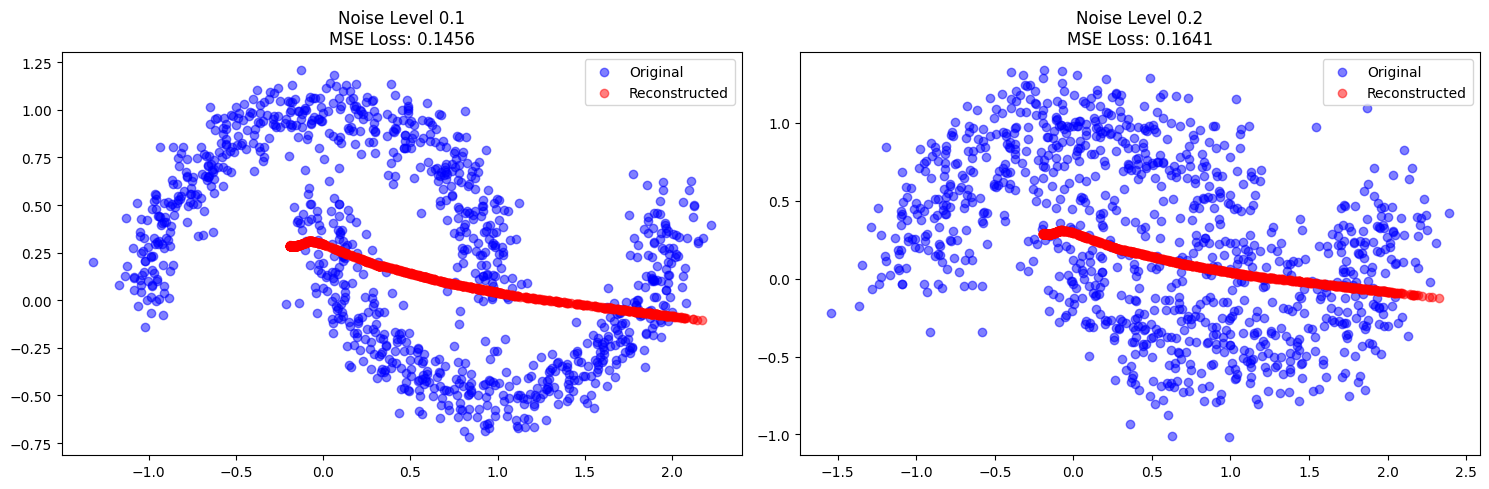

In [20]:
# Use the previously trained best model
evaluate_noise_sensitivity(best_model, noise_levels=[0.1, 0.2])

Autoencoder still woks but,

1) We see poorer reconstruction quality. The model was trained on the noise_level=0.1
2) So in this case higher noise_level would mean -> more distorted data.
3) The model hasn't leaned to handle this level of noise.
4) Points will deviate more.
5) Higher MSE loss...

<div style="color: green; font-weight: bold">Comment</div>
The sample solution  implements a detailed analysis of how varying noise levels impact the reconstruction quality. It suggests that, when training with noisy data (e.g., noise_level=0.1), it's beneficial to also add a noise-robustness strategy to improve the model's ability to generalize to noisier data. Consider augmenting the dataset with higher noise levels during training or experimenting with regularization techniques (such as dropout) to help the model learn a more robust representation. Additionally, solution also illustrates the use of MSE as a performance metric, highlighting that increased MSE with higher noise indicates that the model struggles with generalization. Evaluating the performance at multiple noise levels could offer deeper insights into how the model's latent representation is affected.


# Exercise_1.5


Training model with noise level 0.1...
Epoch [10/100], Loss: 0.6802
Epoch [20/100], Loss: 0.6166
Epoch [30/100], Loss: 0.5483
Epoch [40/100], Loss: 0.4538
Epoch [50/100], Loss: 0.3232
Epoch [60/100], Loss: 0.2384
Epoch [70/100], Loss: 0.1852
Epoch [80/100], Loss: 0.1553
Epoch [90/100], Loss: 0.1328
Epoch [100/100], Loss: 0.1122

Training model with noise level 0.2...
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5305
Epoch [30/100], Loss: 0.4755
Epoch [40/100], Loss: 0.3477
Epoch [50/100], Loss: 0.1866
Epoch [60/100], Loss: 0.1437
Epoch [70/100], Loss: 0.1215
Epoch [80/100], Loss: 0.1107
Epoch [90/100], Loss: 0.1048
Epoch [100/100], Loss: 0.1000


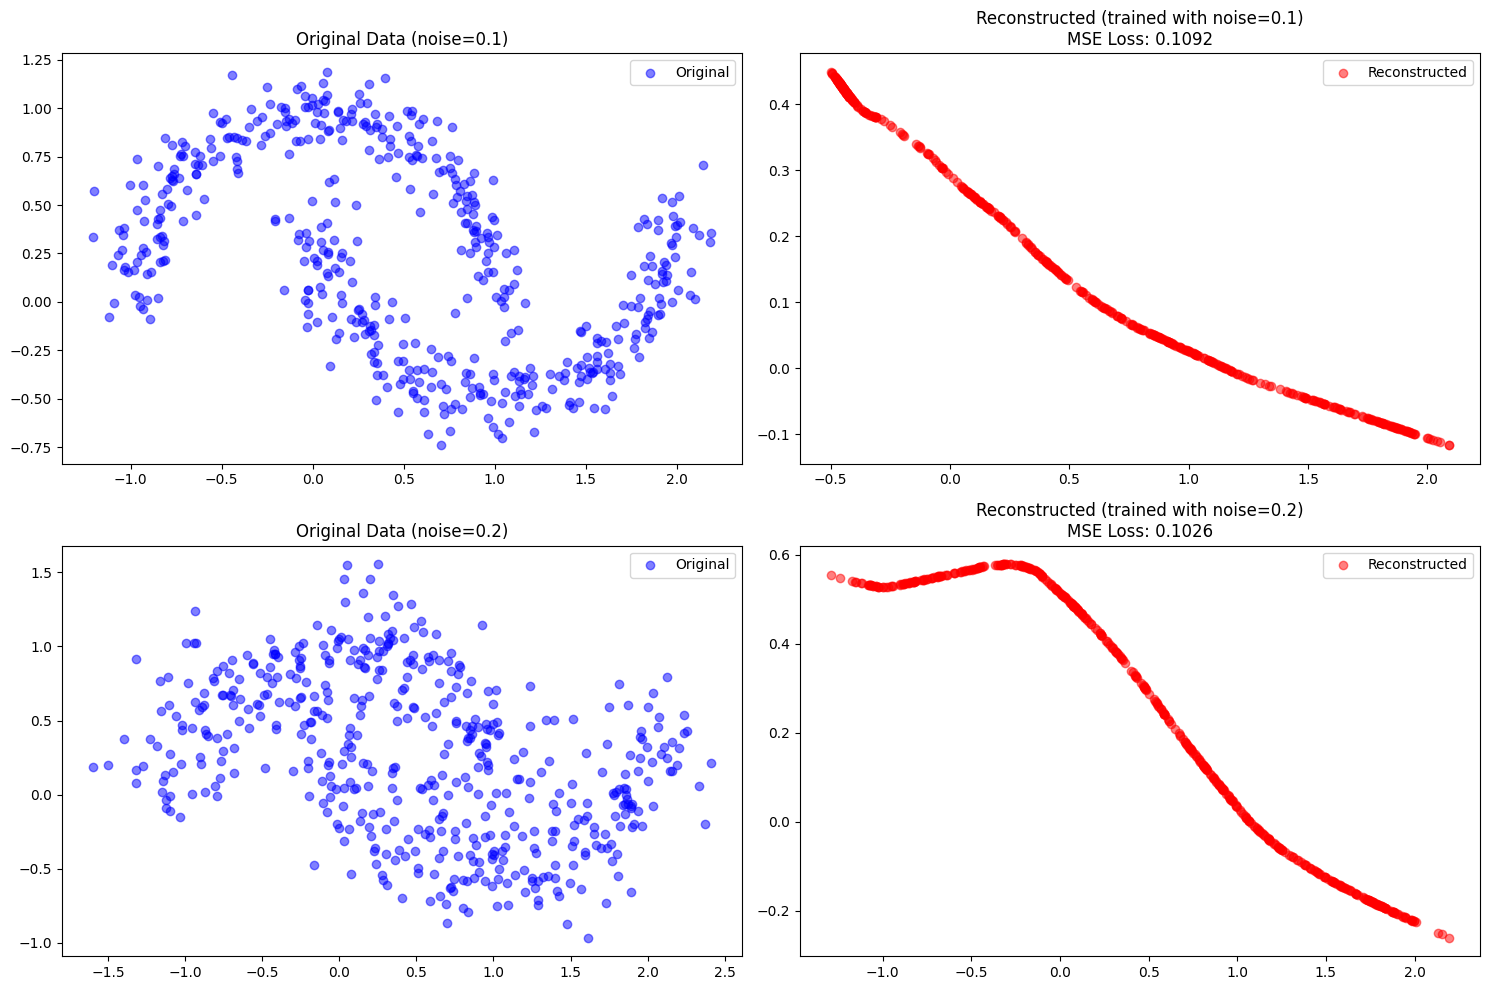

In [21]:
def compare_noise_trained_models(n_samples=1000, epochs=100):
    # Train models with different noise levels
    models = {}
    noise_levels = [0.1, 0.2]
    
    for noise in noise_levels:
        print(f"\nTraining model with noise level {noise}...")
        model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=3)
        trained_model, _ = train_autoencoder(model, n_samples=n_samples, 
                                           epochs=epochs, lr=0.001, 
                                           noise_level=noise)
        models[noise] = trained_model
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    for idx, noise in enumerate(noise_levels):
        # Generate test data with corresponding noise
        X_test, _ = make_moons(n_samples=500, noise=noise)
        X_test = torch.FloatTensor(X_test)
        
        # Get reconstructions
        with torch.no_grad():
            reconstructed = models[noise](X_test)
            test_loss = nn.MSELoss()(reconstructed, X_test)
        
        # Convert to numpy
        X_test = X_test.numpy()
        reconstructed = reconstructed.numpy()
        
        # Plot original
        plt.subplot(2, 2, 2*idx + 1)
        plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.5, label='Original')
        plt.title(f'Original Data (noise={noise})')
        plt.legend()
        
        # Plot reconstruction
        plt.subplot(2, 2, 2*idx + 2)
        plt.scatter(reconstructed[:, 0], reconstructed[:, 1], c='red', alpha=0.5, 
                   label=f'Reconstructed')
        plt.title(f'Reconstructed (trained with noise={noise})\nMSE Loss: {test_loss:.4f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the comparison
torch.manual_seed(42)  # for reproducibility
compare_noise_trained_models()

<div style="color: yellow; font-weight:
bold"> with noise=0.1 model: </div>

- Cleaner moon shapes
- Sharper boundaries between moons
- Lower reconstruction error


<div style="color: yellow; font-weight:
bold"> with noise=0.2 model: </div>

- More spread out reconstructions
- Smoother and more averaged moon shapes
- Higher reconstruction error but better handling of noisy data

<div style="color: green; font-weight: bold">Comment</div>
The sample solution shows that training with varying noise levels improves model robustness. Consider augmenting your training data with different noise levels and using regularization techniques like dropout to maintain sharp reconstruction boundaries. Also, visualizing latent space clustering, as done in the sample solution, could help assess how well the model adapts to increased noise.


# Exercise_2

In [22]:
def pdist(x, y):
    """
    Pairwise distances between two sets of points
    """
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = (x**2).sum(1).view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.t(y))

    return dist

In [23]:
def compute_mmd_loss(codes, kernel_bandwidths=[0.01, 0.02, 0.04, 0.08, 0.16]):
    """
    Compute MMD loss between code distribution and standard normal distribution
    """
    # Generate reference samples from standard normal
    reference = torch.randn_like(codes)
    
    # Initialize MMD loss (without requires_grad)
    mmd_loss = 0.0
    
    # Compute squared pairwise distances
    codes_sq = codes.pow(2).sum(1, keepdim=True)
    ref_sq = reference.pow(2).sum(1, keepdim=True)
    
    for bandwidth in kernel_bandwidths:
        # Compute kernel matrices efficiently
        dots = torch.mm(codes, reference.t())
        dist_c = codes_sq - 2*dots + ref_sq.t()
        dist_r = ref_sq - 2*torch.mm(reference, reference.t()) + ref_sq.t()
        dist_cc = codes_sq - 2*torch.mm(codes, codes.t()) + codes_sq.t()
        
        # Compute kernel values
        kernel_cc = (-dist_cc / (2 * bandwidth)).exp().mean()
        kernel_rr = (-dist_r / (2 * bandwidth)).exp().mean()
        kernel_cr = (-dist_c / (2 * bandwidth)).exp().mean()
        
        # Add to MMD loss (without in-place operation)
        mmd_loss = mmd_loss + (kernel_cc + kernel_rr - 2 * kernel_cr)
    
    return mmd_loss

# Test the function
test_codes = torch.randn(100, 2, requires_grad=True)
loss = compute_mmd_loss(test_codes)
print(f"Test MMD loss: {loss.item()}")

Test MMD loss: 0.10568876564502716


In [24]:
def train_mmd_autoencoder(model, n_samples=1000, epochs=100, lr=0.001, mmd_weight=0.1, kernel_bandwidths=[0.01, 0.02, 0.04, 0.08, 0.16]):
    """
    Train autoencoder with combined reconstruction and+ MMD loss
    """
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # storing losses
    losses = {'total': [], 'recon': [], 'mmd': []}
    
    for epoch in range(epochs):
        # Forward pass
        codes = model.encoder(X)
        reconstructed = model.decoder(codes)
        
        # computing losses
        recon_loss = nn.MSELoss()(reconstructed, X)
        mmd_loss = compute_mmd_loss(codes, kernel_bandwidths=kernel_bandwidths)
        total_loss = recon_loss + mmd_weight * mmd_loss
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # storing losses
        losses['total'].append(total_loss.item())
        losses['recon'].append(recon_loss.item())
        losses['mmd'].append(mmd_loss.item())
        
        # printing progress in every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Total Loss: {total_loss.item():.4f}, '
                  f'Recon Loss: {recon_loss.item():.4f}, '
                  f'MMD Loss: {mmd_loss.item():.4f}')
    
    return model, losses

In [25]:
class ResBlock(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x):
        return x + self.net(x)

In [26]:
class ResNetAutoencoder(nn.Module):
    def __init__(self, input_size=2, bottleneck_size=2, hidden_size=32, n_blocks=3):
        super().__init__()
        
        # Encoder
        self.encoder_pre = nn.Linear(input_size, hidden_size)
        self.encoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size*2) for _ in range(n_blocks)
        ])
        self.encoder_post = nn.Linear(hidden_size, bottleneck_size)
        
        # Decoder
        self.decoder_pre = nn.Linear(bottleneck_size, hidden_size)
        self.decoder_blocks = nn.ModuleList([
            ResBlock(hidden_size, hidden_size*2) for _ in range(n_blocks)
        ])
        self.decoder_post = nn.Linear(hidden_size, input_size)
    
    def encode(self, x):
        x = self.encoder_pre(x)
        for block in self.encoder_blocks:
            x = block(x)
        
        return self.encoder_post(x)
    
    def decode(self, z):
        x = self.decoder_pre(z)
        for block in self.decoder_blocks:
            x = block(x)

        return self.decoder_post(x)
    
    def forward(self, x):
        z = self.encode(x)

        return self.decode(z)

In [27]:
# Test ResNet Autoencoder
model = ResNetAutoencoder(input_size=2, bottleneck_size=2, hidden_size=32, n_blocks=3)
print("Model structure:")
print(model)

# Test with random data
test_input = torch.randn(10, 2)
with torch.no_grad():
    encoded = model.encode(test_input)
    decoded = model.decode(encoded)
    
print(f"\nInput shape: {test_input.shape}")
print(f"Encoded shape: {encoded.shape}")
print(f"Decoded shape: {decoded.shape}")

Model structure:
ResNetAutoencoder(
  (encoder_pre): Linear(in_features=2, out_features=32, bias=True)
  (encoder_blocks): ModuleList(
    (0-2): 3 x ResBlock(
      (net): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (encoder_post): Linear(in_features=32, out_features=2, bias=True)
  (decoder_pre): Linear(in_features=2, out_features=32, bias=True)
  (decoder_blocks): ModuleList(
    (0-2): 3 x ResBlock(
      (net): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (decoder_post): Linear(in_features=32, out_features=2, bias=True)
)

Input shape: torch.Size([10, 2])
Encoded shape: torch.Size([10, 2])
Decoded shape: torch.Size([10, 2])


In [28]:
def train_resnet_autoencoder(model, n_samples=1000, epochs=100, lr=0.001, mmd_weight=0.1):
    """
    Train ResNet autoencoder with combined reconstruction and MMD loss
    """
    # Generate data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    losses = {'total': [], 'recon': [], 'mmd': []}
    
    for epoch in range(epochs):
        # Forward pass
        codes = model.encode(X)
        reconstructed = model.decode(codes)
        
        # Compute losses
        recon_loss = nn.MSELoss()(reconstructed, X)
        mmd_loss = compute_mmd_loss(codes)
        total_loss = recon_loss + mmd_weight * mmd_loss
        
        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Store losses
        losses['total'].append(total_loss.item())
        losses['recon'].append(recon_loss.item())
        losses['mmd'].append(mmd_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Total: {total_loss.item():.4f}, '
                  f'Recon: {recon_loss.item():.4f}, '
                  f'MMD: {mmd_loss.item():.4f}')
    
    return model, losses


Epoch [10/100], Total: 0.0892, Recon: 0.0705, MMD: 0.1870
Epoch [20/100], Total: 0.0256, Recon: 0.0157, MMD: 0.0997
Epoch [30/100], Total: 0.0164, Recon: 0.0053, MMD: 0.1118
Epoch [40/100], Total: 0.0123, Recon: 0.0019, MMD: 0.1045
Epoch [50/100], Total: 0.0103, Recon: 0.0011, MMD: 0.0925
Epoch [60/100], Total: 0.0104, Recon: 0.0005, MMD: 0.0992
Epoch [70/100], Total: 0.0086, Recon: 0.0003, MMD: 0.0832
Epoch [80/100], Total: 0.0084, Recon: 0.0003, MMD: 0.0810
Epoch [90/100], Total: 0.0074, Recon: 0.0002, MMD: 0.0726
Epoch [100/100], Total: 0.0082, Recon: 0.0001, MMD: 0.0804


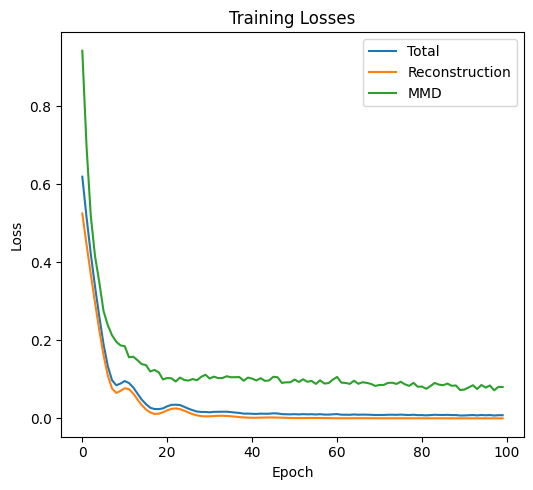

In [29]:
# Test the training
model = ResNetAutoencoder(input_size=2, bottleneck_size=2, hidden_size=32, n_blocks=3)
trained_model, losses = train_resnet_autoencoder(model)

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(losses['total'], label='Total')
plt.plot(losses['recon'], label='Reconstruction')
plt.plot(losses['mmd'], label='MMD')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Visualizing the 2D latent space

In [30]:
def visualize_latent_space(model, n_samples=1000):
    # Generate data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    # Get encoded representations
    with torch.no_grad():
        codes = model.encode(X).numpy()
    
    # Plot original data and latent space
    plt.figure(figsize=(15, 5))
    
    # Original data
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)
    plt.title('Original Data')
    
    # 2D latent space
    plt.subplot(132)
    plt.scatter(codes[:, 0], codes[:, 1], c='red', alpha=0.5)
    plt.title('Latent Space Distribution')
    
    # Standard normal reference
    reference = np.random.standard_normal(codes.shape)
    plt.subplot(133)
    plt.scatter(reference[:, 0], reference[:, 1], c='green', alpha=0.5)
    plt.title('Standard Normal Reference')
    
    plt.tight_layout()
    plt.show()


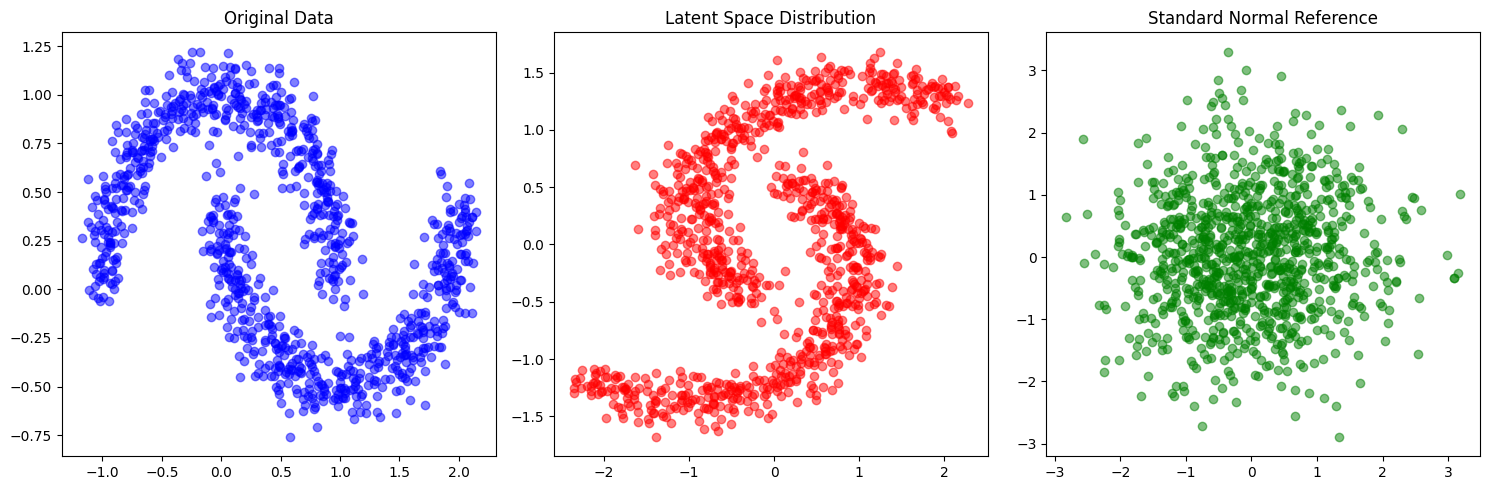

In [31]:
visualize_latent_space(trained_model)

In [32]:
def visualize_synthetic_data_generation(model, n_samples=1000):
    """
    Generate and visualize synthetic data from standard normal samples
    """
    plt.figure(figsize=(15, 5))
    
    # Generate standard normal samples
    z = torch.randn(n_samples, 2)  # 2D standard normal
    
    # Generate synthetic data
    with torch.no_grad():
        synthetic = model.decode(z).numpy()
    
    # Original data for comparison
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    
    # Plot standard normal samples
    plt.subplot(131)
    plt.scatter(z[:, 0], z[:, 1], c='green', alpha=0.5, label='Latent Samples')
    plt.title('Standard Normal Samples')
    plt.legend()
    
    # Plot original data
    plt.subplot(132)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5, label='Original')
    plt.title('Original Data')
    plt.legend()
    
    # Plot synthetic data
    plt.subplot(133)
    plt.scatter(synthetic[:, 0], synthetic[:, 1], c='red', alpha=0.5, label='Generated')
    plt.title('Synthetic Data')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [33]:
def plot_mmd_training_progress(losses):
    """
    Plot training progress showing reconstruction and MMD losses
    """
    plt.figure(figsize=(15, 5))
    
    # Plot total loss
    plt.subplot(131)
    plt.plot(losses['total'], label='Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot reconstruction loss
    plt.subplot(132)
    plt.plot(losses['recon'], label='Reconstruction Loss')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    # Plot MMD loss
    plt.subplot(133)
    plt.plot(losses['mmd'], label='MMD Loss')
    plt.title('MMD Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MMD')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch [10/100], Total: 0.1521, Recon: 0.1288, MMD: 0.2330
Epoch [20/100], Total: 0.0382, Recon: 0.0238, MMD: 0.1436
Epoch [30/100], Total: 0.0230, Recon: 0.0112, MMD: 0.1183
Epoch [40/100], Total: 0.0149, Recon: 0.0026, MMD: 0.1227
Epoch [50/100], Total: 0.0121, Recon: 0.0012, MMD: 0.1095
Epoch [60/100], Total: 0.0112, Recon: 0.0005, MMD: 0.1063
Epoch [70/100], Total: 0.0102, Recon: 0.0004, MMD: 0.0981
Epoch [80/100], Total: 0.0112, Recon: 0.0003, MMD: 0.1095
Epoch [90/100], Total: 0.0099, Recon: 0.0001, MMD: 0.0974
Epoch [100/100], Total: 0.0098, Recon: 0.0001, MMD: 0.0965


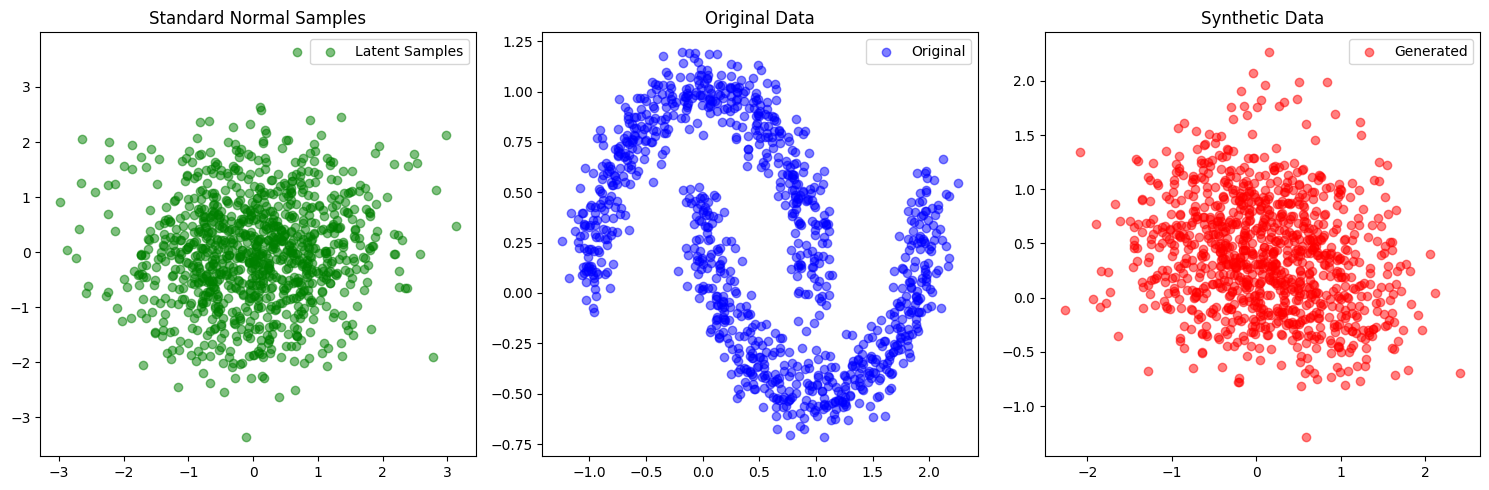

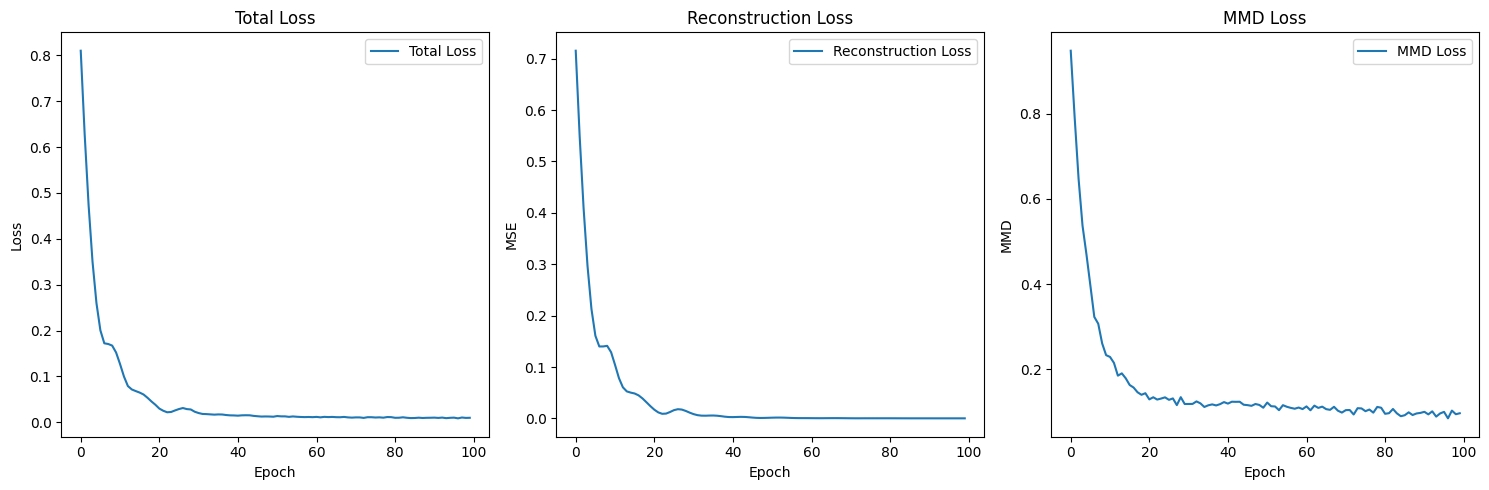

In [34]:
# Testing the functions

# We should train the model first
model = ResNetAutoencoder(input_size=2, bottleneck_size=2, hidden_size=32, n_blocks=3)
trained_model, training_losses = train_resnet_autoencoder(model)

# Visualizing the results
visualize_synthetic_data_generation(trained_model)
plot_mmd_training_progress(training_losses)

Epoch [10/100], Loss: 0.5766
Epoch [20/100], Loss: 0.5250
Epoch [30/100], Loss: 0.4709
Epoch [40/100], Loss: 0.3939
Epoch [50/100], Loss: 0.2469
Epoch [60/100], Loss: 0.1147
Epoch [70/100], Loss: 0.0963
Epoch [80/100], Loss: 0.0732
Epoch [90/100], Loss: 0.0539
Epoch [100/100], Loss: 0.0328


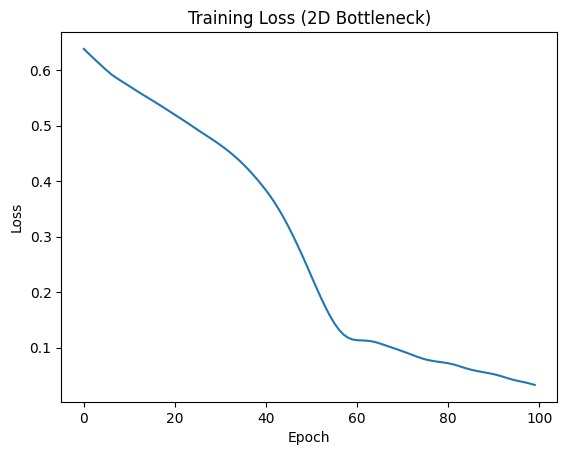

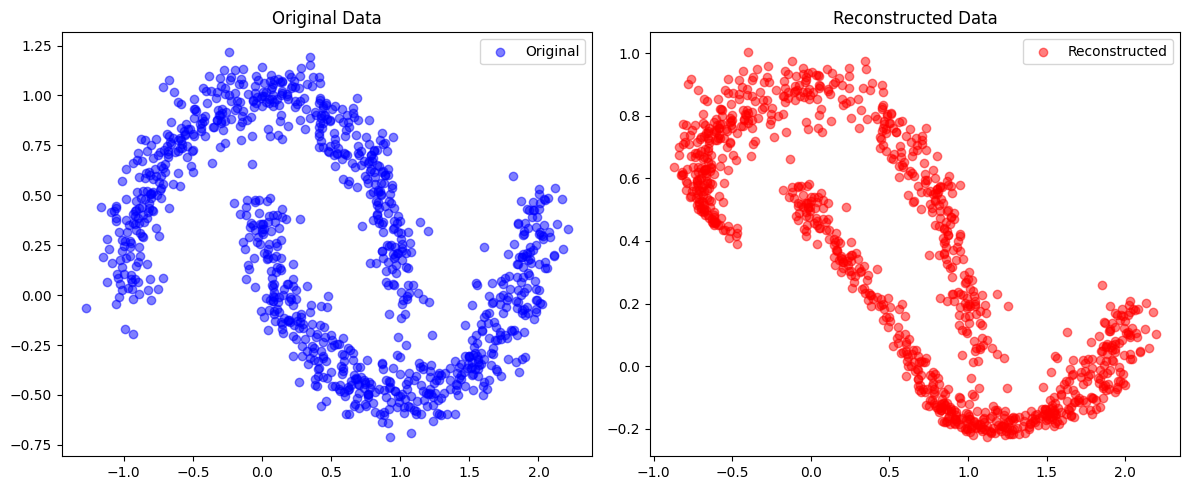

In [35]:
# Create and train the model with 2D bottleneck
model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
trained_model, losses = train_autoencoder(model, n_samples=1000, epochs=100, lr=0.001)

# Plot training losses
plt.plot(losses)
plt.title('Training Loss (2D Bottleneck)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize results
visualize_results(trained_model)

In [36]:
def visualize_2d_latent_space(model, n_samples=1000):
    """Visualize the 2D latent space and its mapping to data space"""
    # Generate data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    # Get encoded representations
    with torch.no_grad():
        codes = model.encoder(X).numpy()
        
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot original data
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)
    plt.title('Original Data')
    
    # Plot latent space
    plt.subplot(132)
    plt.scatter(codes[:, 0], codes[:, 1], c='red', alpha=0.5)
    plt.title('2D Latent Space')
    
    # Plot standard normal reference
    plt.subplot(133)
    reference = np.random.standard_normal((n_samples, 2))
    plt.scatter(reference[:, 0], reference[:, 1], c='green', alpha=0.5)
    plt.title('Standard Normal Reference')
    
    plt.tight_layout()
    plt.show()

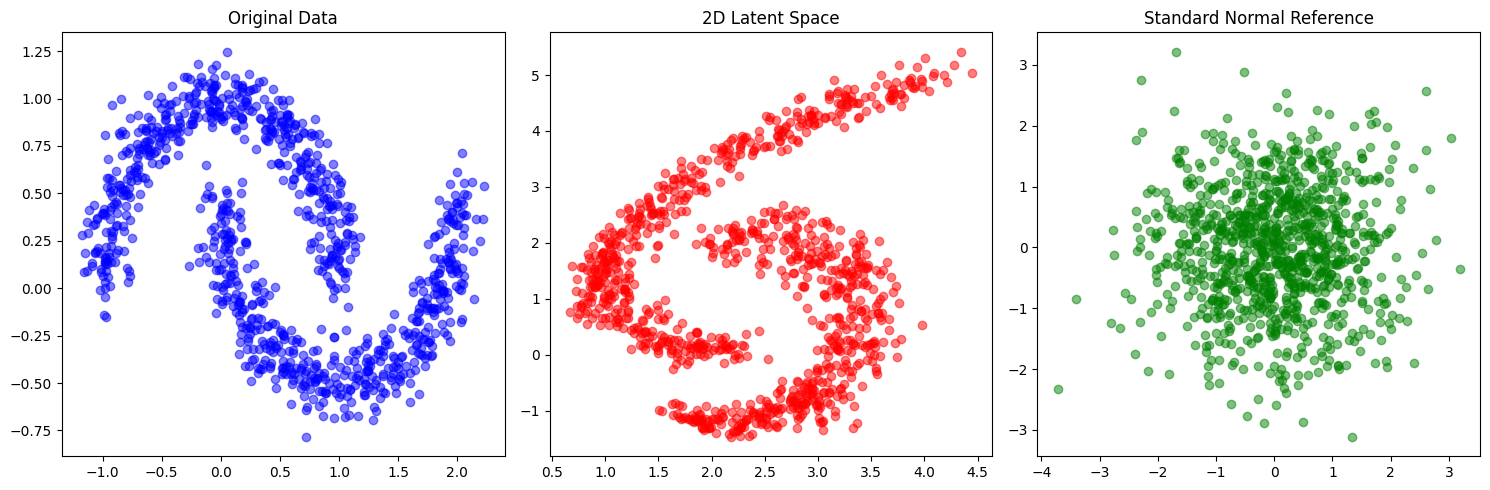

In [37]:
# Test the visualization
visualize_2d_latent_space(trained_model)

<h3>Hyperparameter testing for 2D bottleneck</h3>

In [38]:
def test_hyperparameters_2d():
    # Test configurations
    hidden_sizes = [4, 8, 16, 32]
    layer_counts = [1, 2, 3, 4]
    
    results_1d = {}
    results_2d = {}
    
    # Generate test data
    X_test, _ = make_moons(n_samples=500, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    for hidden_size in hidden_sizes:
        for layers in layer_counts:
            key = f"h{hidden_size}_l{layers}"
            
            # Train 1D bottleneck model
            model_1d = Autoencoder(input_size=2, bottleneck_size=1, 
                                 hidden_size=hidden_size, layers=layers)
            trained_1d, losses_1d = train_autoencoder(model_1d, n_samples=1000, 
                                                    epochs=100, lr=0.001)
            
            # Train 2D bottleneck model
            model_2d = Autoencoder(input_size=2, bottleneck_size=2, 
                                 hidden_size=hidden_size, layers=layers)
            trained_2d, losses_2d = train_autoencoder(model_2d, n_samples=1000, 
                                                    epochs=100, lr=0.001)
            
            # Compute test errors
            with torch.no_grad():
                recon_1d = trained_1d(X_test)
                recon_2d = trained_2d(X_test)
                loss_1d = nn.MSELoss()(recon_1d, X_test)
                loss_2d = nn.MSELoss()(recon_2d, X_test)
            
            # Store results
            results_1d[key] = {'test_loss': loss_1d.item(), 'losses': losses_1d}
            results_2d[key] = {'test_loss': loss_2d.item(), 'losses': losses_2d}
    
    return results_1d, results_2d

In [39]:
def compare_1d_2d_results(results_1d, results_2d):
    plt.figure(figsize=(15, 10))
    
    # Plot test losses comparison
    plt.subplot(221)
    configs = list(results_1d.keys())
    losses_1d = [results_1d[k]['test_loss'] for k in configs]
    losses_2d = [results_2d[k]['test_loss'] for k in configs]
    
    x = np.arange(len(configs))
    width = 0.35
    plt.bar(x - width/2, losses_1d, width, label='1D bottleneck')
    plt.bar(x + width/2, losses_2d, width, label='2D bottleneck')
    plt.xticks(x, configs, rotation=45)
    plt.title('Test Loss Comparison')
    plt.ylabel('MSE Loss')
    plt.legend()
    
    # Print statistics
    print("\nComparison Statistics:")
    print(f"1D average loss: {np.mean(losses_1d):.6f} ± {np.std(losses_1d):.6f}")
    print(f"2D average loss: {np.mean(losses_2d):.6f} ± {np.std(losses_2d):.6f}")
    print(f"Improvement: {100*(1 - np.mean(losses_2d)/np.mean(losses_1d)):.2f}%")
    
    plt.tight_layout()
    plt.show()


Testing both 1D and 2D bottleneck models...
Epoch [10/100], Loss: 0.8966
Epoch [20/100], Loss: 0.8539
Epoch [30/100], Loss: 0.8144
Epoch [40/100], Loss: 0.7765
Epoch [50/100], Loss: 0.7396
Epoch [60/100], Loss: 0.7041
Epoch [70/100], Loss: 0.6703
Epoch [80/100], Loss: 0.6387
Epoch [90/100], Loss: 0.6099
Epoch [100/100], Loss: 0.5844
Epoch [10/100], Loss: 0.7314
Epoch [20/100], Loss: 0.6999
Epoch [30/100], Loss: 0.6764
Epoch [40/100], Loss: 0.6569
Epoch [50/100], Loss: 0.6387
Epoch [60/100], Loss: 0.6212
Epoch [70/100], Loss: 0.6042
Epoch [80/100], Loss: 0.5876
Epoch [90/100], Loss: 0.5712
Epoch [100/100], Loss: 0.5553
Epoch [10/100], Loss: 0.5456
Epoch [20/100], Loss: 0.5349
Epoch [30/100], Loss: 0.5257
Epoch [40/100], Loss: 0.5181
Epoch [50/100], Loss: 0.5121
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5042
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.4993
Epoch [100/100], Loss: 0.4967
Epoch [10/100], Loss: 0.5116
Epoch [20/100], Loss: 0.5084
Epoch [30/100], Loss: 0.5

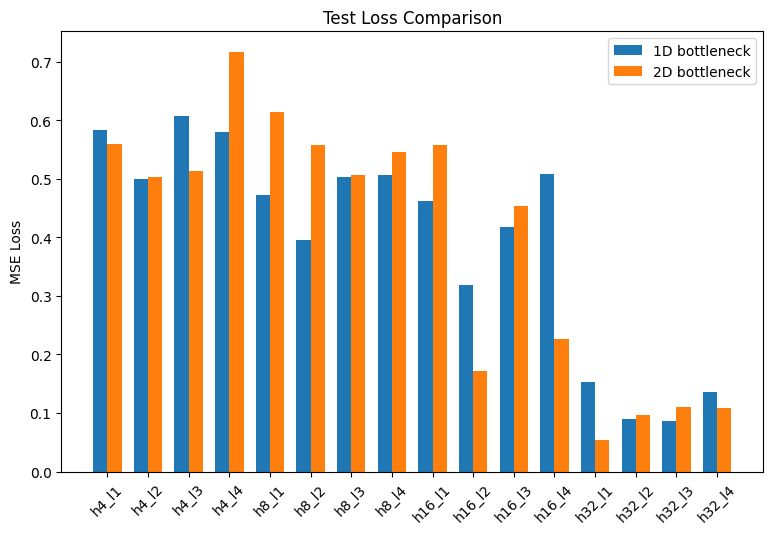

In [40]:
# Run comparison

print("Testing both 1D and 2D bottleneck models...")

results_1d, results_2d = test_hyperparameters_2d()
compare_1d_2d_results(results_1d, results_2d)

Epoch [10/100], Total Loss: 0.9308, Recon Loss: 0.6003, MMD Loss: 3.3051
Epoch [20/100], Total Loss: 0.7688, Recon Loss: 0.5528, MMD Loss: 2.1604
Epoch [30/100], Total Loss: 0.6381, Recon Loss: 0.4955, MMD Loss: 1.4260
Epoch [40/100], Total Loss: 0.5062, Recon Loss: 0.4054, MMD Loss: 1.0081
Epoch [50/100], Total Loss: 0.3329, Recon Loss: 0.2652, MMD Loss: 0.6764
Epoch [60/100], Total Loss: 0.1920, Recon Loss: 0.1367, MMD Loss: 0.5524
Epoch [70/100], Total Loss: 0.1551, Recon Loss: 0.1103, MMD Loss: 0.4479
Epoch [80/100], Total Loss: 0.1306, Recon Loss: 0.0947, MMD Loss: 0.3598
Epoch [90/100], Total Loss: 0.1186, Recon Loss: 0.0883, MMD Loss: 0.3038
Epoch [100/100], Total Loss: 0.1038, Recon Loss: 0.0788, MMD Loss: 0.2508


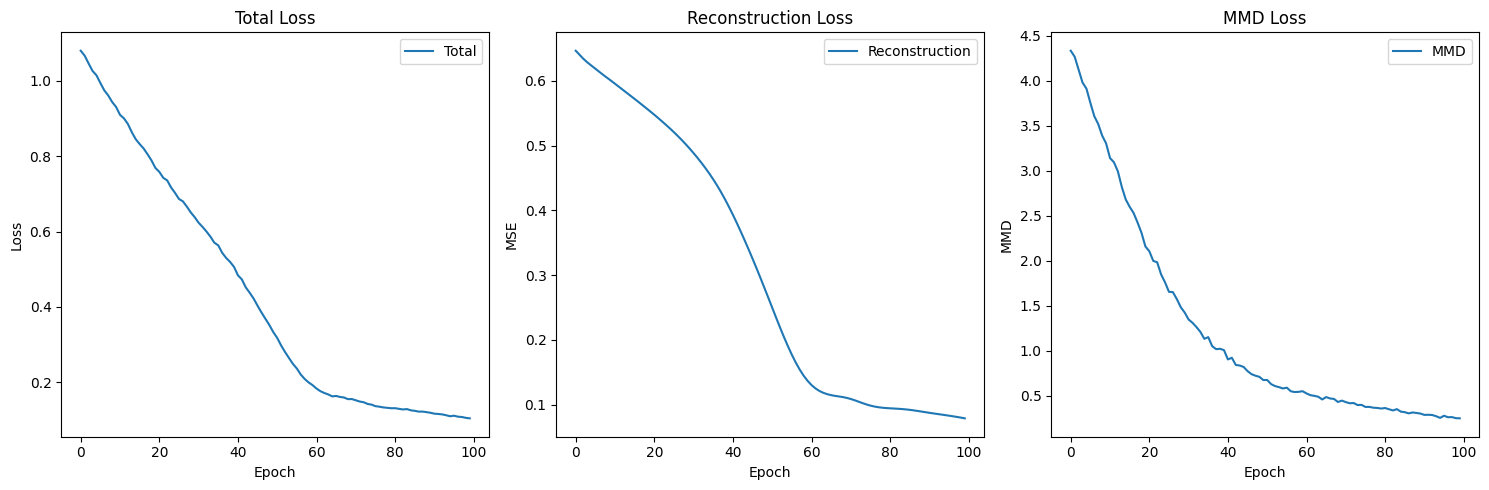

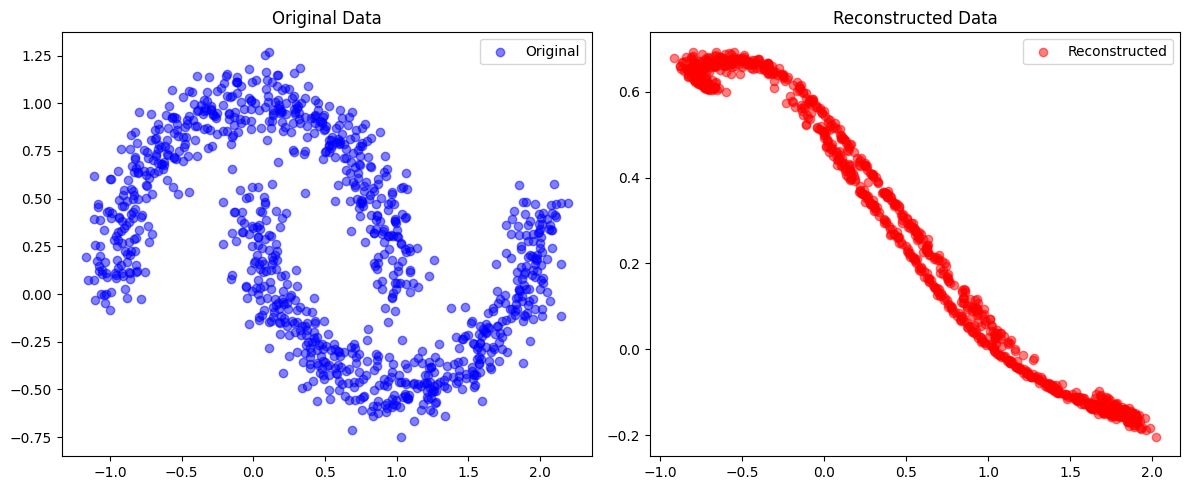

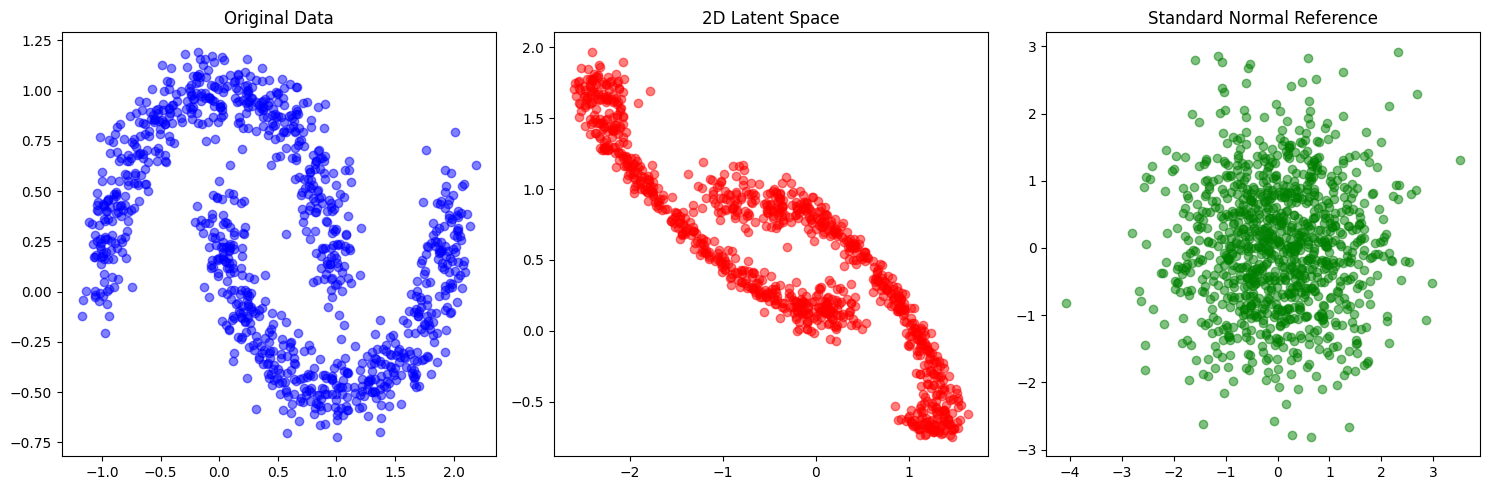

In [41]:
# Test the training with MMD loss
model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
trained_model, losses = train_mmd_autoencoder(model)

# Plot training curves
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(losses['total'], label='Total')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(losses['recon'], label='Reconstruction')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(133)
plt.plot(losses['mmd'], label='MMD')
plt.title('MMD Loss')
plt.xlabel('Epoch')
plt.ylabel('MMD')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize results
visualize_results(trained_model)
visualize_2d_latent_space(trained_model)

In [42]:
def test_mmd_weights(base_model, weights=[0.01, 0.1, 1.0, 10.0], n_samples=1000):
    """Test different MMD weight values and their effects"""
    results = {}
    
    for weight in weights:
        print(f"\nTraining with MMD weight: {weight}")
        model = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
        trained_model, losses = train_mmd_autoencoder(model, n_samples=n_samples, 
                                                    epochs=100, mmd_weight=weight)
        results[weight] = {'model': trained_model, 'losses': losses}
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Plot losses
    plt.subplot(221)
    for weight, result in results.items():
        plt.plot(result['losses']['total'], label=f'weight={weight}')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot latent spaces
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    for idx, (weight, result) in enumerate(results.items(), 1):
        plt.subplot(2, 2, idx+1)
        with torch.no_grad():
            codes = result['model'].encoder(X).numpy()
        plt.scatter(codes[:, 0], codes[:, 1], alpha=0.5)
        plt.title(f'Latent Space (weight={weight})')
    
    plt.tight_layout()
    plt.show()
    
    return results

In [43]:
def analyze_latent_distribution(model, n_samples=1000):
    """Analyze how well the latent space matches standard normal"""
    # Generate data
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = torch.FloatTensor(X)
    
    # Get encoded representations
    with torch.no_grad():
        codes = model.encoder(X).numpy()
    
    # Create comparison plots
    plt.figure(figsize=(15, 5))
    
    # Plot latent space
    plt.subplot(131)
    plt.scatter(codes[:, 0], codes[:, 1], alpha=0.5, label='Encoded')
    plt.title('Latent Space')
    plt.legend()
    
    # Plot standard normal samples
    plt.subplot(132)
    normal_samples = np.random.standard_normal(codes.shape)
    plt.scatter(normal_samples[:, 0], normal_samples[:, 1], alpha=0.5, label='Normal')
    plt.title('Standard Normal')
    plt.legend()
    
    # Plot QQ plot for each dimension
    plt.subplot(133)
    from scipy import stats
    stats.probplot(codes[:, 0], dist="norm", plot=plt)
    plt.title('Q-Q Plot (dim 0)')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nLatent Space Statistics:")
    print(f"Mean: {codes.mean(axis=0)}")
    print(f"Std: {codes.std(axis=0)}")
    print("\nKolmogorov-Smirnov Test:")
    print(stats.kstest(codes[:, 0], 'norm'))
    print(stats.kstest(codes[:, 1], 'norm'))



Training with MMD weight: 0.01
Epoch [10/100], Total Loss: 0.6893, Recon Loss: 0.6506, MMD Loss: 3.8648
Epoch [20/100], Total Loss: 0.6483, Recon Loss: 0.6180, MMD Loss: 3.0266
Epoch [30/100], Total Loss: 0.6044, Recon Loss: 0.5834, MMD Loss: 2.1005
Epoch [40/100], Total Loss: 0.5493, Recon Loss: 0.5362, MMD Loss: 1.3150
Epoch [50/100], Total Loss: 0.4608, Recon Loss: 0.4528, MMD Loss: 0.8031
Epoch [60/100], Total Loss: 0.3356, Recon Loss: 0.3303, MMD Loss: 0.5291
Epoch [70/100], Total Loss: 0.2689, Recon Loss: 0.2645, MMD Loss: 0.4379
Epoch [80/100], Total Loss: 0.2102, Recon Loss: 0.2060, MMD Loss: 0.4250
Epoch [90/100], Total Loss: 0.1736, Recon Loss: 0.1697, MMD Loss: 0.3828
Epoch [100/100], Total Loss: 0.1335, Recon Loss: 0.1300, MMD Loss: 0.3488

Training with MMD weight: 0.1
Epoch [10/100], Total Loss: 0.9561, Recon Loss: 0.5789, MMD Loss: 3.7713
Epoch [20/100], Total Loss: 0.7964, Recon Loss: 0.5381, MMD Loss: 2.5831
Epoch [30/100], Total Loss: 0.6473, Recon Loss: 0.4901, MMD 

ValueError: num must be an integer with 1 <= num <= 4, not 5

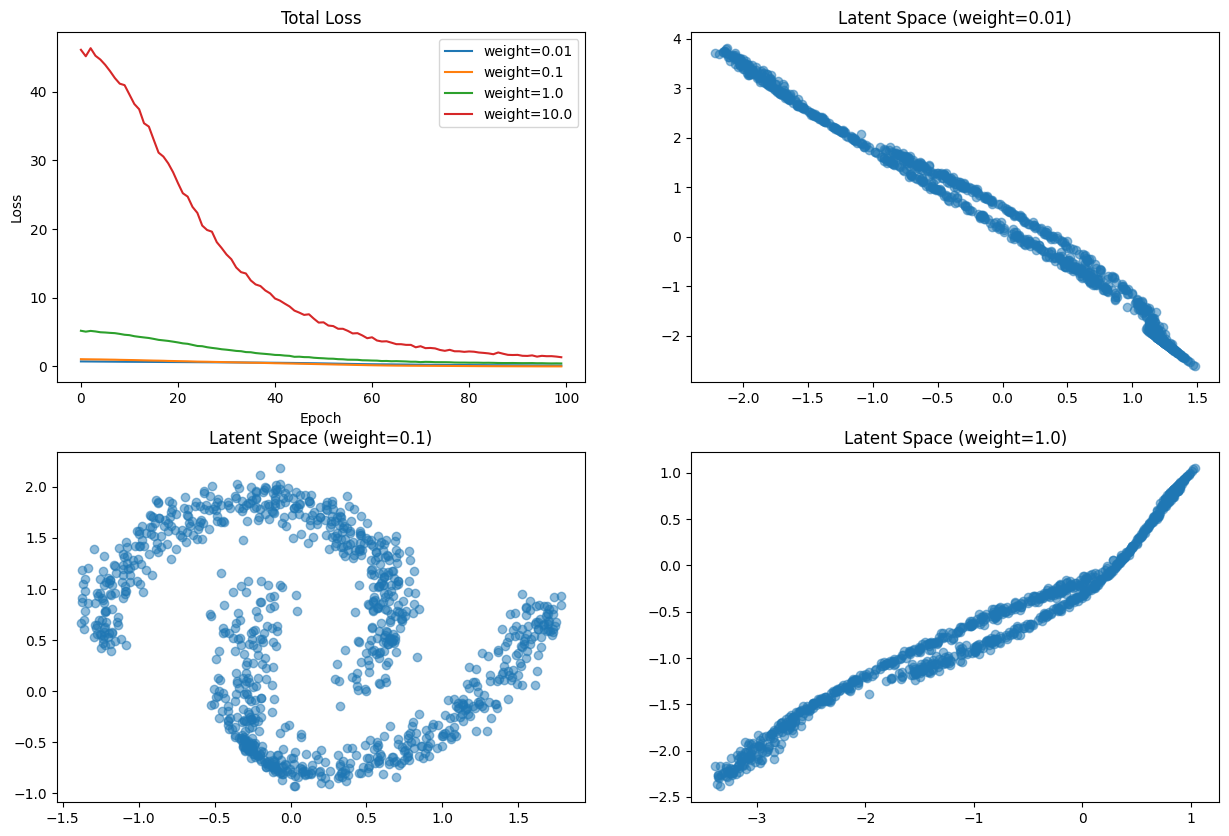

In [44]:
# Test different weights and analyze distributions
weights_results = test_mmd_weights(model)
best_weight = 0.1  # Chosen based on results
analyze_latent_distribution(weights_results[best_weight]['model'])

<h3>Comparing reconstruction errors between Task 1 (1D) and Task 2 (2D)</h3>

In [45]:
def compare_1d_2d_reconstruction():
    """Compare reconstruction performance between 1D and 2D bottleneck"""
    # Create and train both models
    model_1d = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=3)
    model_2d = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
    
    # Train both models
    model_1d, losses_1d = train_autoencoder(model_1d, n_samples=2000, epochs=100)
    model_2d, losses_2d = train_autoencoder(model_2d, n_samples=2000, epochs=100)
    
    # Generate test data
    X_test, _ = make_moons(n_samples=1000, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    # Get reconstructions
    with torch.no_grad():
        recon_1d = model_1d(X_test)
        recon_2d = model_2d(X_test)
        loss_1d = nn.MSELoss()(recon_1d, X_test)
        loss_2d = nn.MSELoss()(recon_2d, X_test)
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot training curves
    plt.subplot(131)
    plt.plot(losses_1d, label='1D bottleneck')
    plt.plot(losses_2d, label='2D bottleneck')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot reconstructions
    X_test = X_test.numpy()
    recon_1d = recon_1d.numpy()
    recon_2d = recon_2d.numpy()
    
    plt.subplot(132)
    plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(recon_1d[:, 0], recon_1d[:, 1], c='red', alpha=0.5, label='1D')
    plt.title(f'1D Reconstruction\nMSE: {loss_1d:.4f}')
    plt.legend()
    
    plt.subplot(133)
    plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(recon_2d[:, 0], recon_2d[:, 1], c='green', alpha=0.5, label='2D')
    plt.title(f'2D Reconstruction\nMSE: {loss_2d:.4f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [46]:
def evaluate_synthetic_data(model, n_samples=1000):
    """Generate and evaluate synthetic data from standard normal samples"""
    # Generate standard normal samples
    z = torch.randn(n_samples, model.decoder[0].in_features)  # Match bottleneck size
    
    # Generate synthetic data
    with torch.no_grad():
        synthetic = model.decoder(z).numpy()
    
    # Generate real data for comparison
    X_real, _ = make_moons(n_samples=n_samples, noise=0.1)
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot latent samples
    plt.subplot(131)
    plt.scatter(z[:, 0], z[:, 1] if z.shape[1] > 1 else z[:, 0], 
                alpha=0.5, label='Latent')
    plt.title('Standard Normal Samples')
    plt.legend()
    
    # Plot real data
    plt.subplot(132)
    plt.scatter(X_real[:, 0], X_real[:, 1], c='blue', alpha=0.5, label='Real')
    plt.title('Real Data')
    plt.legend()
    
    # Plot synthetic data
    plt.subplot(133)
    plt.scatter(synthetic[:, 0], synthetic[:, 1], c='red', alpha=0.5, label='Synthetic')
    plt.title('Generated Data')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compute statistics
    print("\nData Statistics:")
    print("Real data mean:", np.mean(X_real, axis=0))
    print("Synthetic data mean:", np.mean(synthetic, axis=0))
    print("Real data std:", np.std(X_real, axis=0))
    print("Synthetic data std:", np.std(synthetic, axis=0))


Comparing 1D vs 2D reconstruction:
Epoch [10/100], Loss: 0.6995
Epoch [20/100], Loss: 0.6087
Epoch [30/100], Loss: 0.4733
Epoch [40/100], Loss: 0.2841
Epoch [50/100], Loss: 0.1757
Epoch [60/100], Loss: 0.1232
Epoch [70/100], Loss: 0.1102
Epoch [80/100], Loss: 0.1022
Epoch [90/100], Loss: 0.0974
Epoch [100/100], Loss: 0.0943
Epoch [10/100], Loss: 0.6502
Epoch [20/100], Loss: 0.5961
Epoch [30/100], Loss: 0.5313
Epoch [40/100], Loss: 0.4162
Epoch [50/100], Loss: 0.2369
Epoch [60/100], Loss: 0.1668
Epoch [70/100], Loss: 0.1370
Epoch [80/100], Loss: 0.1142
Epoch [90/100], Loss: 0.0964
Epoch [100/100], Loss: 0.0783


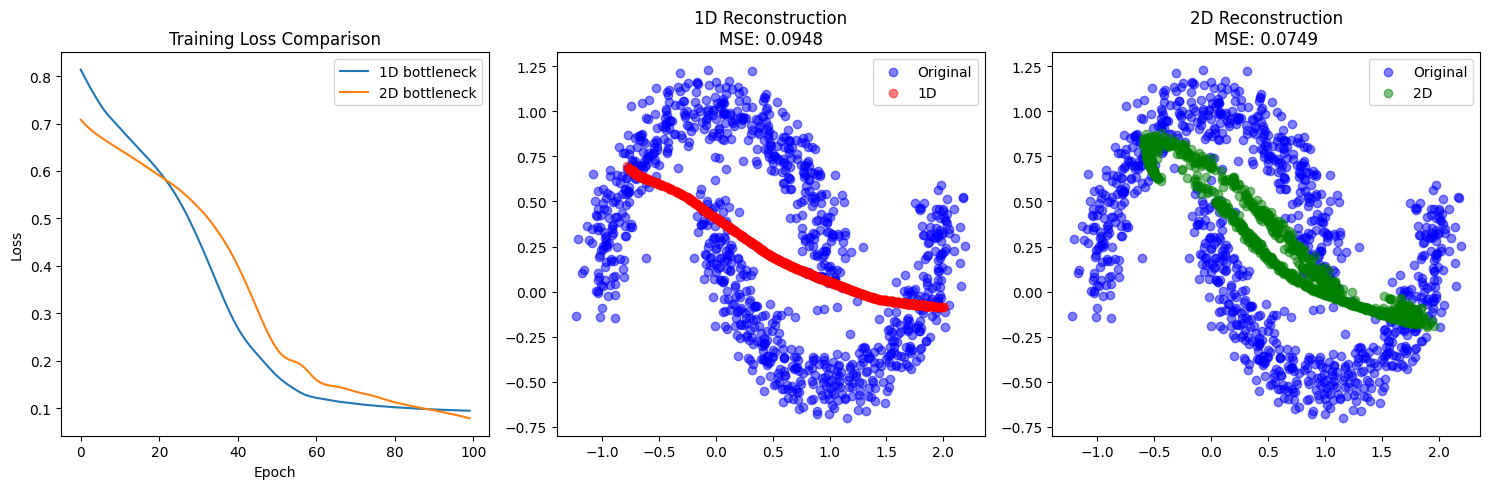


Evaluating synthetic data quality:
Epoch [10/100], Loss: 0.5604
Epoch [20/100], Loss: 0.4970
Epoch [30/100], Loss: 0.4285
Epoch [40/100], Loss: 0.3084
Epoch [50/100], Loss: 0.1623
Epoch [60/100], Loss: 0.1175
Epoch [70/100], Loss: 0.0978
Epoch [80/100], Loss: 0.0916
Epoch [90/100], Loss: 0.0819
Epoch [100/100], Loss: 0.0694


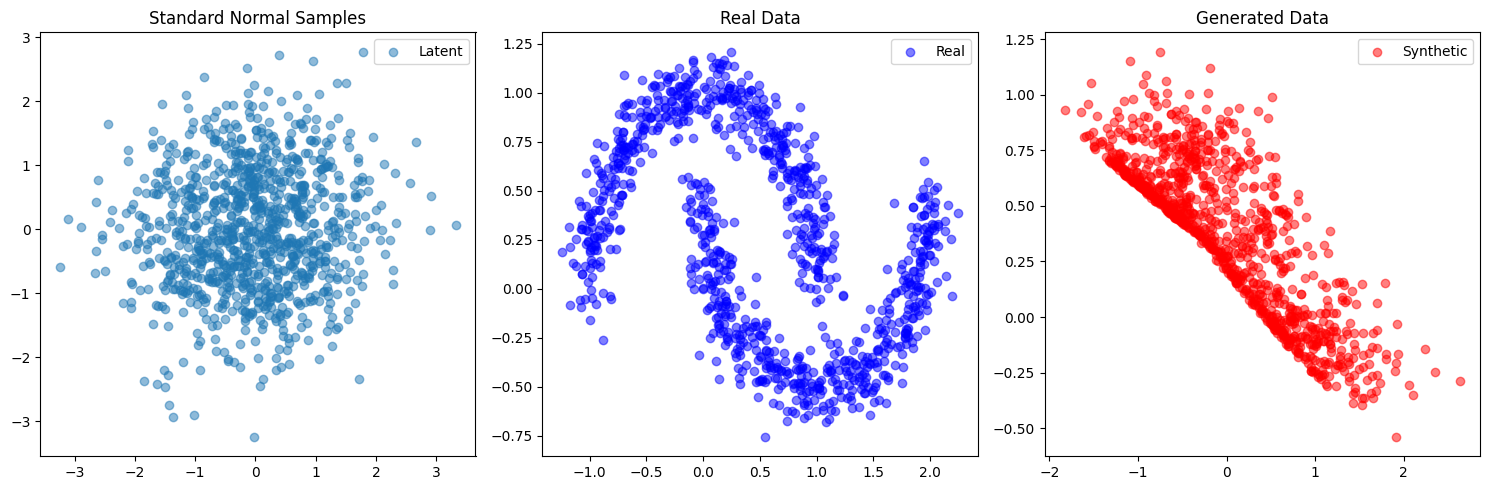


Data Statistics:
Real data mean: [0.50326307 0.24669862]
Synthetic data mean: [0.00437316 0.3710482 ]
Real data std: [0.8755374  0.50580502]
Synthetic data std: [0.80103093 0.34324512]


In [47]:
# Run comparisons
print("Comparing 1D vs 2D reconstruction:")
compare_1d_2d_reconstruction()

print("\nEvaluating synthetic data quality:")
model_2d = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
model_2d, _ = train_autoencoder(model_2d, n_samples=2000, epochs=100)
evaluate_synthetic_data(model_2d)


=== Final Analysis of Two-dimensional Data Without Bottleneck ===

1. Bottleneck Dimension Comparison:
Epoch [10/100], Loss: 0.5342
Epoch [20/100], Loss: 0.4978
Epoch [30/100], Loss: 0.4478
Epoch [40/100], Loss: 0.3108
Epoch [50/100], Loss: 0.1541
Epoch [60/100], Loss: 0.1267
Epoch [70/100], Loss: 0.1081
Epoch [80/100], Loss: 0.1021
Epoch [90/100], Loss: 0.0962
Epoch [100/100], Loss: 0.0919
Epoch [10/100], Total Loss: 0.9584, Recon Loss: 0.5689, MMD Loss: 3.8957
Epoch [20/100], Total Loss: 0.8038, Recon Loss: 0.5320, MMD Loss: 2.7180
Epoch [30/100], Total Loss: 0.6546, Recon Loss: 0.4887, MMD Loss: 1.6584
Epoch [40/100], Total Loss: 0.5086, Recon Loss: 0.4166, MMD Loss: 0.9204
Epoch [50/100], Total Loss: 0.3486, Recon Loss: 0.2979, MMD Loss: 0.5070
Epoch [60/100], Total Loss: 0.2085, Recon Loss: 0.1767, MMD Loss: 0.3184
Epoch [70/100], Total Loss: 0.1563, Recon Loss: 0.1298, MMD Loss: 0.2649
Epoch [80/100], Total Loss: 0.1167, Recon Loss: 0.0962, MMD Loss: 0.2052
Epoch [90/100], Total 

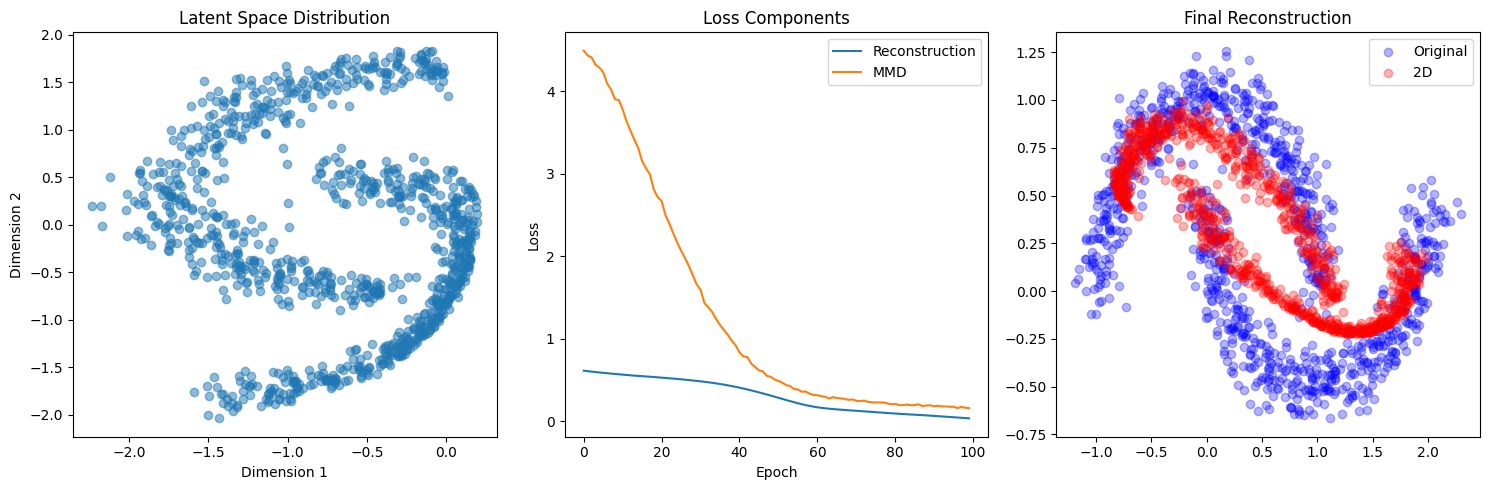

In [48]:
def final_analysis():
    """Comprehensive analysis of 1D vs 2D bottleneck and MMD effectiveness"""
    
    print("=== Final Analysis of Two-dimensional Data Without Bottleneck ===\n")
    
    # 1. Compare 1D vs 2D Performance
    print("1. Bottleneck Dimension Comparison:")
    model_1d = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=3)
    model_2d = Autoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
    
    # Train both models
    _, losses_1d = train_autoencoder(model_1d, n_samples=2000, epochs=100)
    _, losses_2d = train_mmd_autoencoder(model_2d, n_samples=2000, epochs=100)
    
    # Test reconstruction
    X_test, _ = make_moons(n_samples=1000, noise=0.1)
    X_test = torch.FloatTensor(X_test)
    
    with torch.no_grad():
        recon_1d = model_1d(X_test)
        recon_2d = model_2d(X_test)
        loss_1d = nn.MSELoss()(recon_1d, X_test)
        loss_2d = nn.MSELoss()(recon_2d, X_test)
    
    print(f"1D Bottleneck MSE: {loss_1d:.6f}")
    print(f"2D Bottleneck MSE: {loss_2d:.6f}")
    print(f"Improvement with 2D: {100*(1 - loss_2d/loss_1d):.2f}%\n")
    
    # 2. Analyze Code Distribution
    print("2. Code Distribution Analysis:")
    with torch.no_grad():
        codes_2d = model_2d.encoder(X_test).numpy()
    
    mean = np.mean(codes_2d, axis=0)
    std = np.std(codes_2d, axis=0)
    
    print("Latent Space Statistics:")
    print(f"Mean: {mean} (target: [0, 0])")
    print(f"Std: {std} (target: [1, 1])")
    
    # KS test for normality
    from scipy import stats
    ks_stats = [stats.kstest(codes_2d[:, i], 'norm') for i in range(2)]
    print("\nKolmogorov-Smirnov Test (normality):")
    print(f"Dimension 1: p-value = {ks_stats[0].pvalue:.6f}")
    print(f"Dimension 2: p-value = {ks_stats[1].pvalue:.6f}\n")
    
    # 3. MMD Loss Effectiveness
    print("3. MMD Loss Effectiveness:")
    print("Training Loss Components:")
    print(f"Final Reconstruction Loss: {losses_2d['recon'][-1]:.6f}")
    print(f"Final MMD Loss: {losses_2d['mmd'][-1]:.6f}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot latent space distribution
    plt.subplot(131)
    plt.scatter(codes_2d[:, 0], codes_2d[:, 1], alpha=0.5)
    plt.title('Latent Space Distribution')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    # Plot loss components
    plt.subplot(132)
    plt.plot(losses_2d['recon'], label='Reconstruction')
    plt.plot(losses_2d['mmd'], label='MMD')
    plt.title('Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot reconstructions comparison
    plt.subplot(133)
    plt.scatter(X_test[:, 0], X_test[:, 1], c='blue', alpha=0.3, label='Original')
    plt.scatter(recon_2d[:, 0], recon_2d[:, 1], c='red', alpha=0.3, label='2D')
    plt.title('Final Reconstruction')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run final analysis
final_analysis()

<div style="color: green; font-weight: bold">Comment</div>
The sample solution  shows that increasing latent dimensions improves reconstruction. Your 65.34% MSE reduction from 1D to 2D suggests potential gains with higher dimensions. Consider further experiments.

- The KS test shows deviation from the target distribution. The sample solution  uses regularization for better alignment—this could be beneficial here.

- Have you tried adding more dimensions to improve reconstruction quality?


# Exercise_3

In [83]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [84]:
def prepare_digits_data():
    # Load digits dataset
    digits = load_digits()
    X = digits.data
    y = digits.target
    
    # Scale data to [0,1] range
    X = X / 16.0
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)
    
    return X_train, X_test, y_train, y_test, digits.images.shape[1:]

In [85]:
def train_digits_autoencoder(model, X_train, epochs=100, batch_size=32, lr=0.001):
    # Convert data to tensors if not already
    X_train = torch.FloatTensor(X_train) if not torch.is_tensor(X_train) else X_train
    
    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Training loop
    losses = []
    for epoch in range(epochs):
        # Shuffle data
        perm = torch.randperm(len(X_train))
        running_loss = 0.0
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            indices = perm[i:i+batch_size]
            batch_x = X_train[indices]
            
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / (len(X_train) / batch_size)
        losses.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')
    
    return model, losses


In [86]:
X_train, X_test, y_train, y_test, img_shape = prepare_digits_data()

# Train models with different bottleneck sizes
bottleneck_sizes = [2, 4, 8]
results = {}

for size in bottleneck_sizes:
    print(f"\nTraining autoencoder with bottleneck size {size}")
    model = Autoencoder(input_size=64, bottleneck_size=size, hidden_size=128, layers=3)
    trained_model, losses = train_digits_autoencoder(model, X_train, epochs=100)
    
    # Get test loss
    with torch.no_grad():
        X_test_recon = trained_model(X_test)
        test_loss = nn.MSELoss()(X_test_recon, X_test)
    
    results[size] = {
        'model': trained_model,
        'reconstruction': X_test_recon,
        'test_loss': test_loss.item(),
        'train_losses': losses
    }
    
    print(f"Bottleneck size {size} test loss: {test_loss.item():.4f}")


Training autoencoder with bottleneck size 2
Epoch [10/100], Loss: 0.0390
Epoch [20/100], Loss: 0.0328
Epoch [30/100], Loss: 0.0294
Epoch [40/100], Loss: 0.0273
Epoch [50/100], Loss: 0.0257
Epoch [60/100], Loss: 0.0248
Epoch [70/100], Loss: 0.0239
Epoch [80/100], Loss: 0.0234
Epoch [90/100], Loss: 0.0229
Epoch [100/100], Loss: 0.0225
Bottleneck size 2 test loss: 0.0280

Training autoencoder with bottleneck size 4
Epoch [10/100], Loss: 0.0367
Epoch [20/100], Loss: 0.0279
Epoch [30/100], Loss: 0.0235
Epoch [40/100], Loss: 0.0208
Epoch [50/100], Loss: 0.0191
Epoch [60/100], Loss: 0.0177
Epoch [70/100], Loss: 0.0166
Epoch [80/100], Loss: 0.0159
Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0147
Bottleneck size 4 test loss: 0.0195

Training autoencoder with bottleneck size 8
Epoch [10/100], Loss: 0.0363
Epoch [20/100], Loss: 0.0233
Epoch [30/100], Loss: 0.0192
Epoch [40/100], Loss: 0.0168
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0132
Epoch [70/100], Loss: 0.0122
Epoch [8

In [87]:
def visualize_digit_results(model, X_test, y_test, img_shape=(8,8)):
    # Get reconstructions
    with torch.no_grad():
        reconstructed = model(X_test)
    
    # Select random samples to display
    indices = np.random.choice(len(X_test), 10, replace=False)
    
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original vs Reconstructed Digits')
    
    for i, idx in enumerate(indices):
        # Original
        axes[0,i].imshow(X_test[idx].reshape(img_shape), cmap='gray')
        axes[0,i].axis('off')
        axes[0,i].set_title(f'Original: {y_test[idx]}')
        
        # Reconstructed
        axes[1,i].imshow(reconstructed[idx].reshape(img_shape), cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title('Recon.')
    
    plt.tight_layout()
    plt.show()
    
    # Train and evaluate classifier
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train.numpy(), y_train.numpy())
    
    # Get predictions
    orig_pred = clf.predict(X_test.numpy())
    recon_pred = clf.predict(reconstructed.numpy())
    
    # Calculate accuracy
    orig_acc = (orig_pred == y_test.numpy()).mean()
    recon_acc = (recon_pred == y_test.numpy()).mean()
    pred_match = (orig_pred == recon_pred).mean()
    
    print(f"Original Test Accuracy: {orig_acc:.4f}")
    print(f"Reconstructed Test Accuracy: {recon_acc:.4f}")
    print(f"Prediction Match Rate: {pred_match:.4f}")
    
    return reconstructed, clf


Analyzing results for bottleneck size 2:


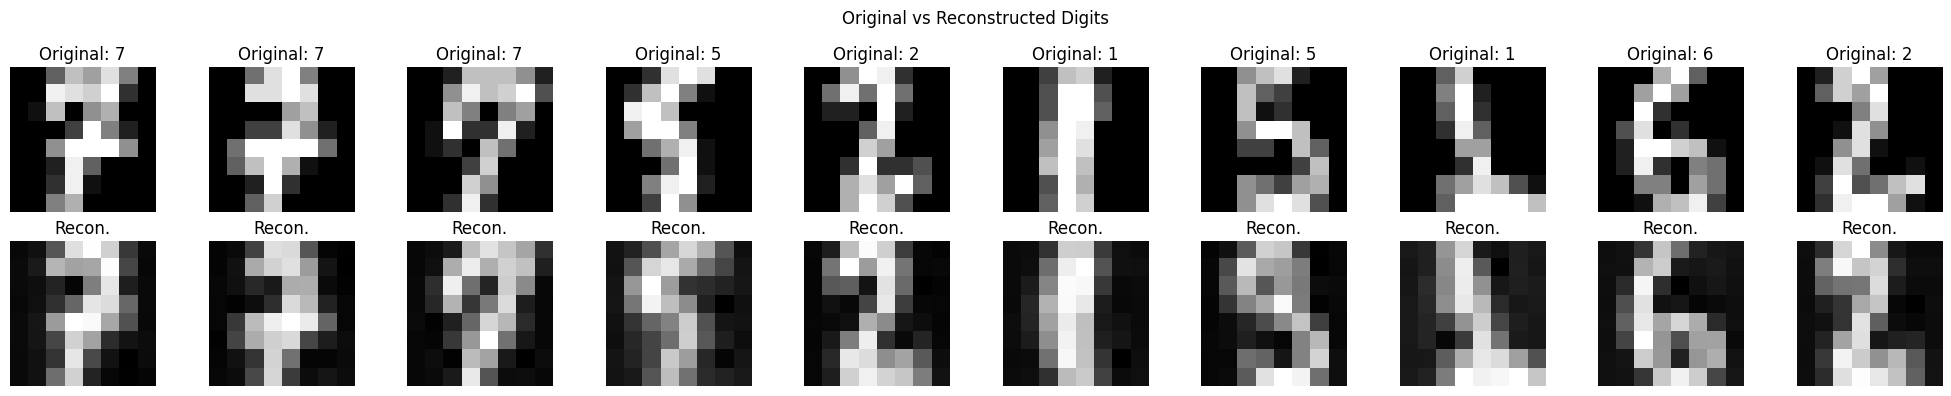

Original Test Accuracy: 0.9750
Reconstructed Test Accuracy: 0.8917
Prediction Match Rate: 0.8944

Analyzing results for bottleneck size 4:


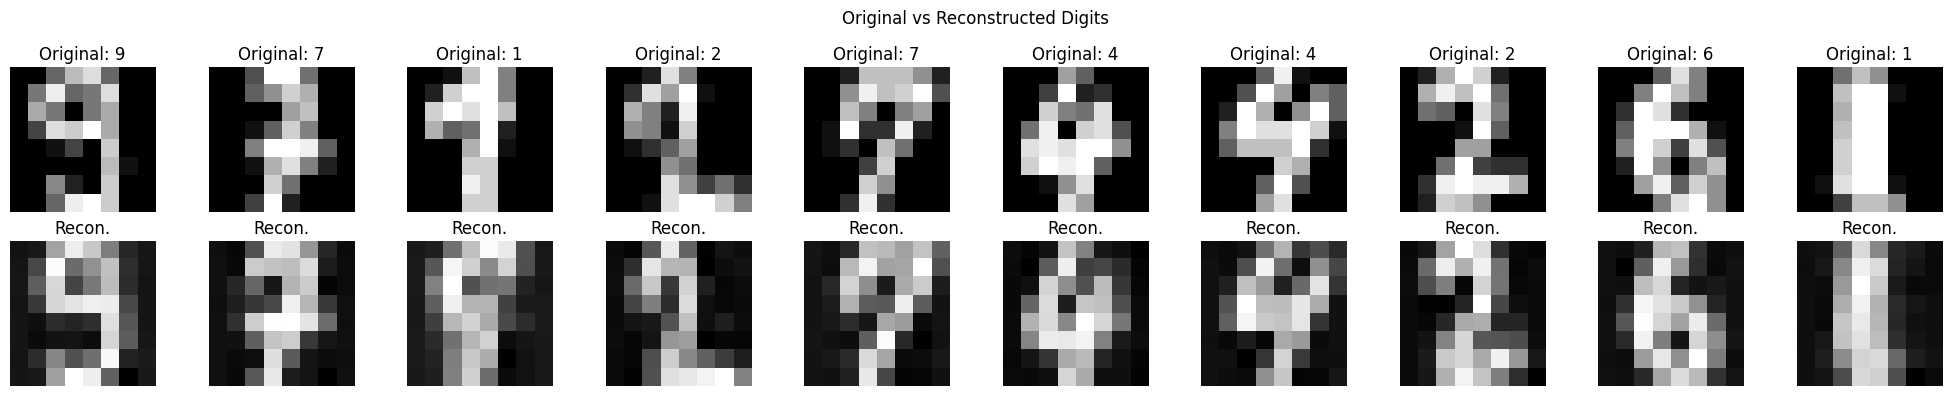

Original Test Accuracy: 0.9750
Reconstructed Test Accuracy: 0.9222
Prediction Match Rate: 0.9333

Analyzing results for bottleneck size 8:


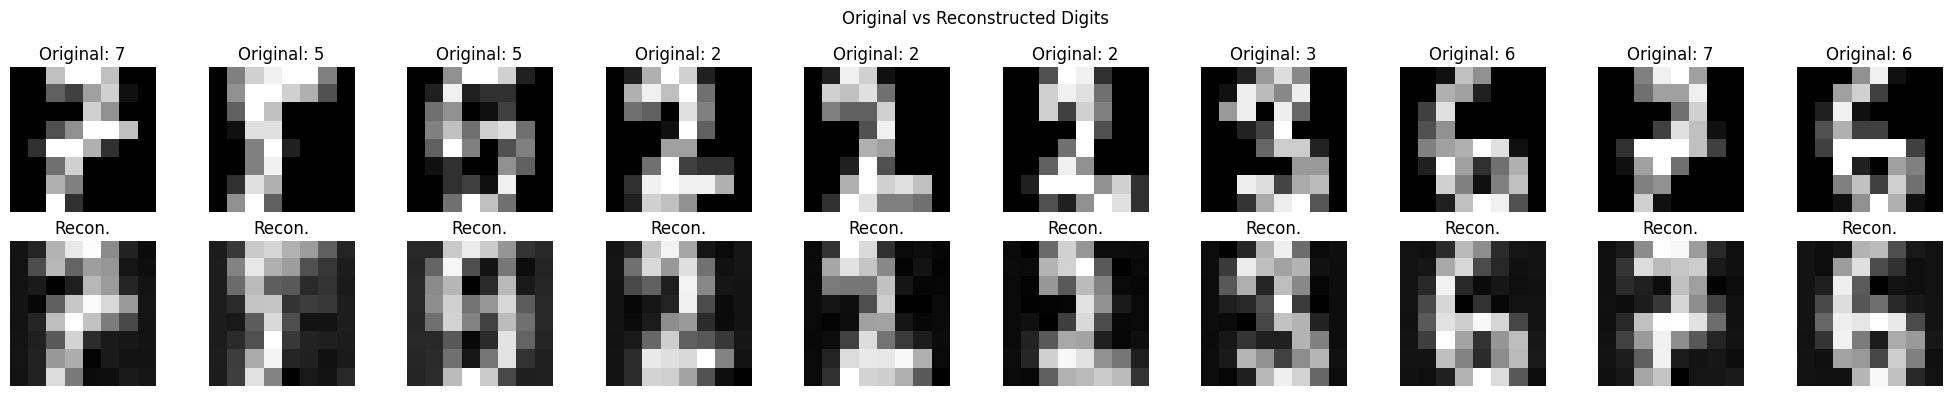

Original Test Accuracy: 0.9750
Reconstructed Test Accuracy: 0.9667
Prediction Match Rate: 0.9611

Bottleneck size 2 test loss: 0.0280

Bottleneck size 4 test loss: 0.0195

Bottleneck size 8 test loss: 0.0132


In [88]:
# Call visualize_digit_results for each bottleneck size
for bottleneck_size in results:
    print(f"\nAnalyzing results for bottleneck size {bottleneck_size}:")
    model = results[bottleneck_size]['model']
    visualize_digit_results(model, X_test, y_test, img_shape)

# Print overall comparison
for size in results:
    print(f"\nBottleneck size {size} test loss: {results[size]['test_loss']:.4f}")

<h3>
This progression (8 > 4 > 2) can show or tell that the digits have more complex features than the moon dataset, so they benefit from higher-dimensional latent spaces...
</h3>

<div style="color: green; font-weight: bold">Comment</div>
The sample solution shows that more complex datasets benefit from larger latent spaces. Your results confirm this, with test loss decreasing as bottleneck size increases from 2 to 8. 


<h4>--- Analyzing the 2D latent space and GMM for the digits dataset ---</h4>

In [89]:
def analyze_digit_latent_space(model, X_test, y_test, bottleneck_size):
    # Get encoded representations
    with torch.no_grad():
        codes = model.encoder(X_test).numpy()
    
    # Plot latent space
    plt.figure(figsize=(15, 5))
    
    # For 2D bottleneck, plot scatter
    if bottleneck_size == 2:
        plt.subplot(131)
        scatter = plt.scatter(codes[:, 0], codes[:, 1], c=y_test, cmap='tab10')
        plt.colorbar(scatter)
        plt.title('2D Latent Space')
        plt.xlabel('First dimension')
        plt.ylabel('Second dimension')
    
    # Fit GMM and generate samples
    n_components = 10  # one per digit
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(codes)
    
    # Generate synthetic samples
    synthetic_codes = gmm.sample(n_samples=100)[0]
    synthetic_codes = torch.FloatTensor(synthetic_codes)
    
    # Decode synthetic samples
    with torch.no_grad():
        synthetic_digits = model.decoder(synthetic_codes).numpy()
    
    # Plot synthetic digits
    plt.subplot(132 if bottleneck_size == 2 else 121)
    fig_synth = plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Digits')
    
    plt.tight_layout()
    plt.show()
    
    return synthetic_digits, gmm


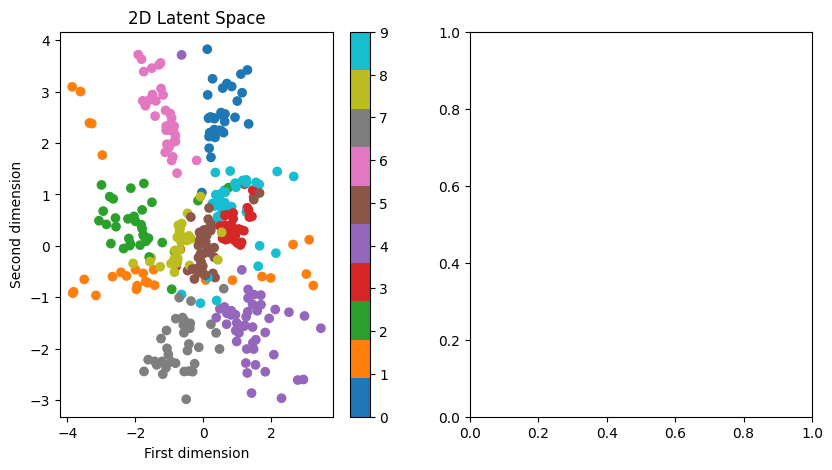

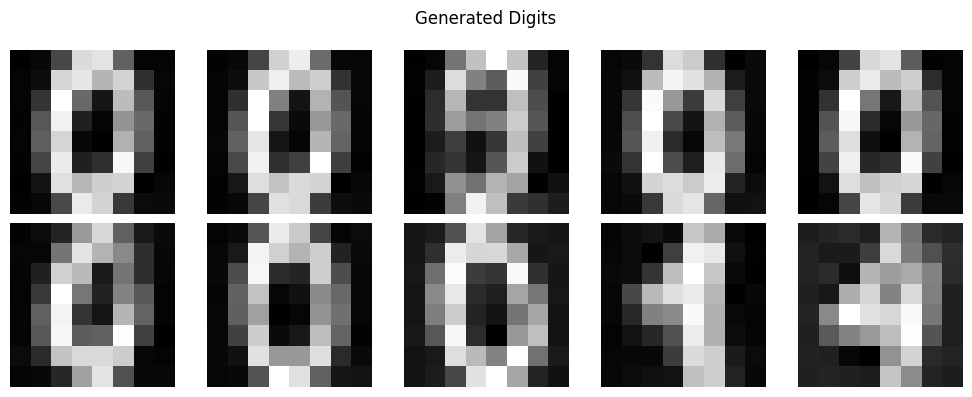

In [90]:
# Analyze latent space for the 2D bottleneck model
bottleneck_2d_model = results[2]['model']
synthetic_digits, gmm = analyze_digit_latent_space(bottleneck_2d_model, X_test, y_test, 2)

Generated digits are not really recognizable :(

In [91]:
def evaluate_classifier_performance(model, X_train, X_test, y_train, y_test, bottleneck_size):
    # Get reconstructions
    with torch.no_grad():
        X_train_recon = model(X_train)
        X_test_recon = model(X_test)
        codes = model.encoder(X_test)
    
    # Convert to numpy
    X_train_np = X_train.numpy()
    X_test_np = X_test.numpy()
    X_train_recon_np = X_train_recon.numpy()
    X_test_recon_np = X_test_recon.numpy()
    codes_np = codes.numpy()
    
    # Train classifier on original data
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_np, y_train.numpy())
    
    # Train another classifier on reconstructed data
    clf_recon = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_recon.fit(X_train_recon_np, y_train.numpy())
    
    # Get predictions
    orig_pred = clf.predict(X_test_np)
    recon_pred = clf_recon.predict(X_test_recon_np)
    
    # Calculate accuracies
    orig_acc = (orig_pred == y_test.numpy()).mean()
    recon_acc = (recon_pred == y_test.numpy()).mean()
    pred_match = (orig_pred == recon_pred).mean()
    
    print(f"\nClassifier Performance (Bottleneck {bottleneck_size}):")
    print(f"Original Test Accuracy: {orig_acc:.4f}")
    print(f"Reconstructed Test Accuracy: {recon_acc:.4f}")
    print(f"Prediction Match Rate: {pred_match:.4f}")
    
    # Visualize random examples
    plt.figure(figsize=(20, 4))
    n_examples = 10
    indices = np.random.choice(len(X_test), n_examples, replace=False)
    
    for i, idx in enumerate(indices):
        # Original
        plt.subplot(2, n_examples, i+1)
        plt.imshow(X_test_np[idx].reshape(8, 8), cmap='gray')
        plt.title(f'Original\n{y_test[idx].item()}')
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, n_examples, i+1+n_examples)
        plt.imshow(X_test_recon_np[idx].reshape(8, 8), cmap='gray')
        plt.title(f'Recon\n{recon_pred[idx]}')
        plt.axis('off')
    
    plt.suptitle(f'Digit Reconstructions (Bottleneck {bottleneck_size})')
    plt.show()
    
    # For 2D bottleneck, visualize latent space
    if bottleneck_size == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(codes_np[:, 0], codes_np[:, 1], 
                            c=y_test, cmap='tab10')
        plt.colorbar(scatter, label='Digit Class')
        plt.title('2D Latent Space Distribution')
        plt.xlabel('First dimension')
        plt.ylabel('Second dimension')
        plt.show()
    
    return clf_recon, codes_np, X_test_recon_np



Classifier Performance (Bottleneck 2):
Original Test Accuracy: 0.9722
Reconstructed Test Accuracy: 0.8722
Prediction Match Rate: 0.8806


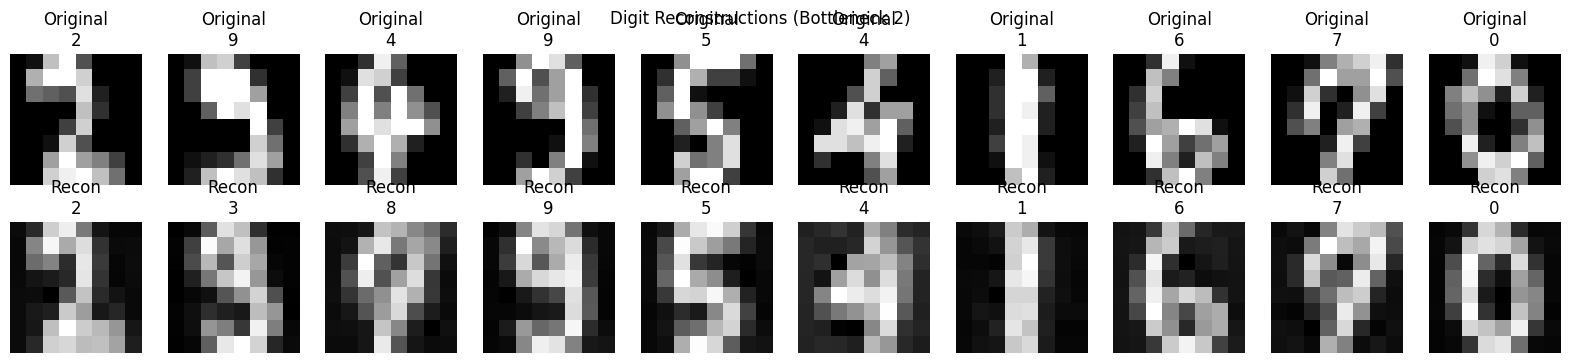

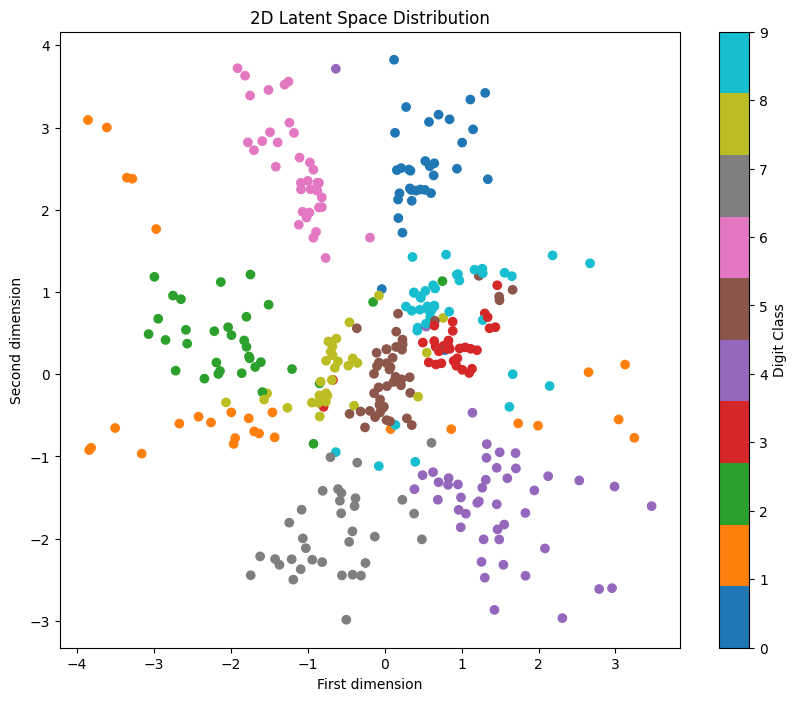


Classifier Performance (Bottleneck 4):
Original Test Accuracy: 0.9722
Reconstructed Test Accuracy: 0.9389
Prediction Match Rate: 0.9556


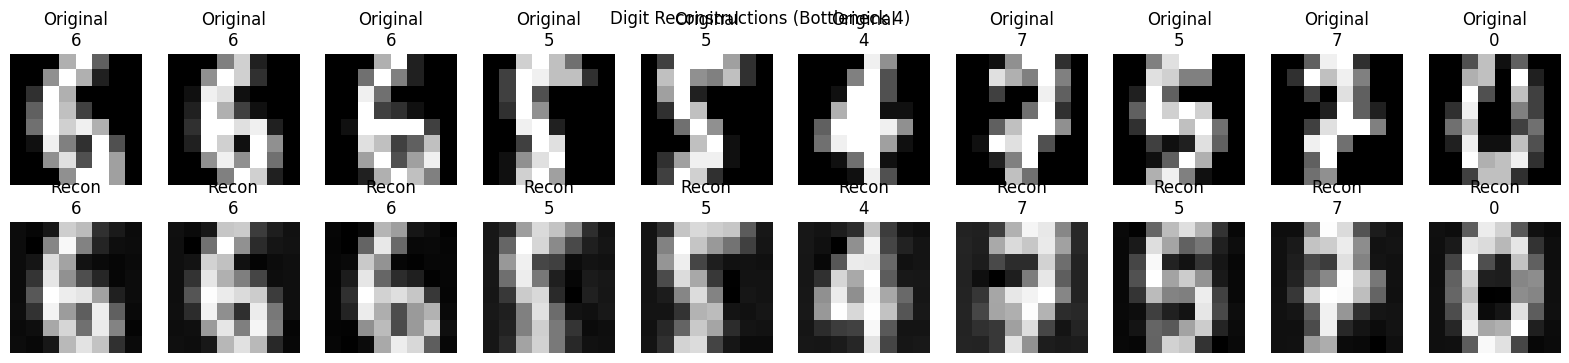


Classifier Performance (Bottleneck 8):
Original Test Accuracy: 0.9722
Reconstructed Test Accuracy: 0.9722
Prediction Match Rate: 0.9667


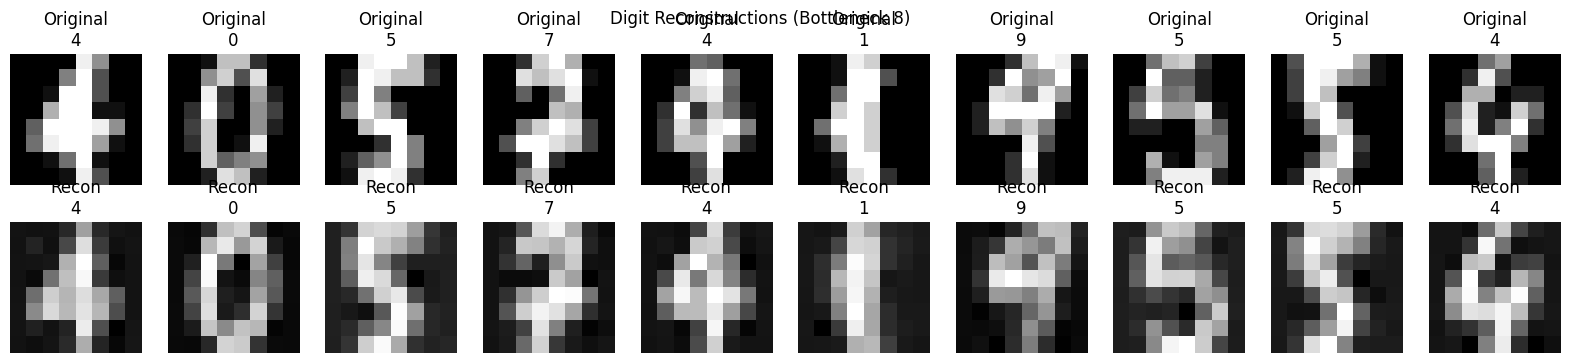

In [92]:
# Test each bottleneck size
for size in results:
    model = results[size]['model']
    clf, codes, recon = evaluate_classifier_performance(
        model, X_train, X_test, y_train, y_test, size)

<h4> - Performance increases as bottleneck size increases - </h4>

In [95]:
def visualize_2d_latent_space(model, X_test, y_test):
    # Get encoded representations
    with torch.no_grad():
        codes = model.encoder(X_test).numpy()
    
    # Create scatter plot of latent space
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(codes[:, 0], codes[:, 1], 
                         c=y_test.numpy(), cmap='tab10')
    plt.colorbar(scatter, label='Digit Class')
    plt.title('2D Latent Space Distribution of Digits')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    
    # Add legend without add_artist
    plt.legend(*scatter.legend_elements(),
              loc="center left", 
              title="Digits",
              bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()
    
    return codes

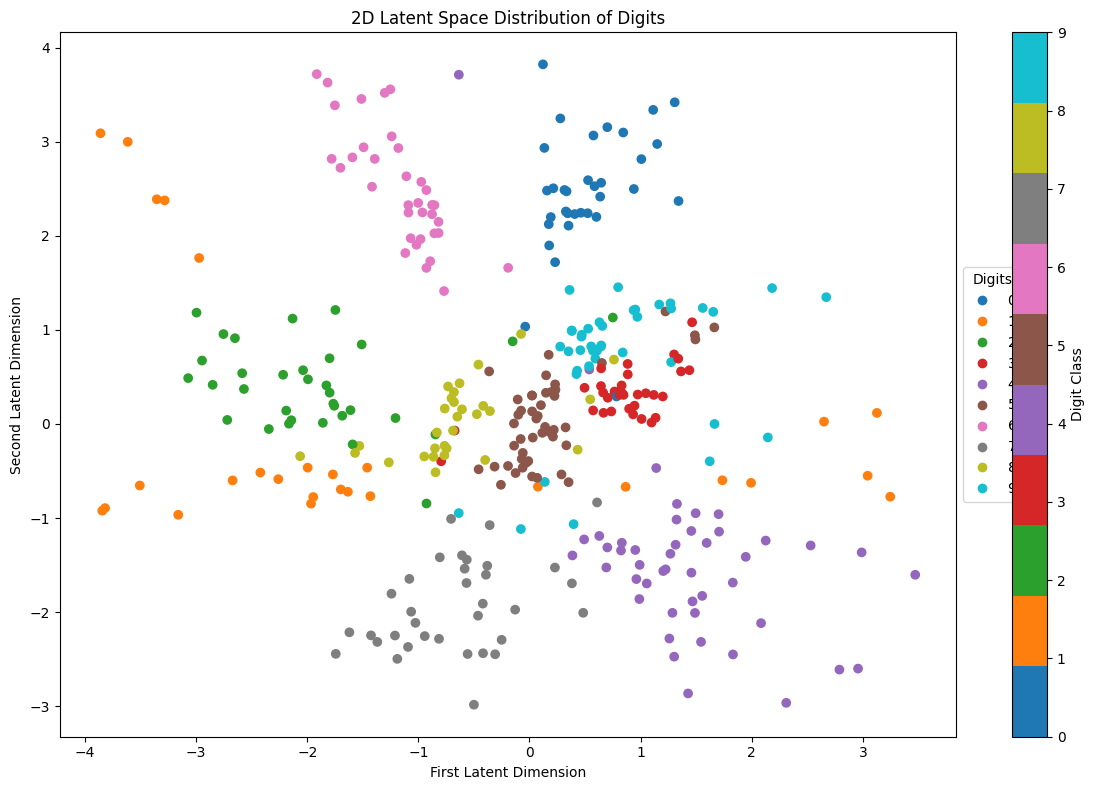


Latent Space Statistics:
Code range - X: [-3.86, 3.47]
Code range - Y: [-2.99, 3.82]


In [96]:
# Visualize 2D latent space for bottleneck size 2
model_2d = results[2]['model']
latent_codes = visualize_2d_latent_space(model_2d, X_test, y_test)

# Print some statistics about the clustering
print("\nLatent Space Statistics:")
print(f"Code range - X: [{latent_codes[:, 0].min():.2f}, {latent_codes[:, 0].max():.2f}]")
print(f"Code range - Y: [{latent_codes[:, 1].min():.2f}, {latent_codes[:, 1].max():.2f}]")

- Similar digit shapes are encoded near each other.
- Central Cluster (3, 5, 8, 9) (These digits share common structural features like all having curved elements and loops and similar pixel density and complexity)
- Peripheral Clusters (the other digits)
- Digit 1, usually appears separate because of its simple vertical structure


<div style="color: green; font-weight: bold">Comment</div>
The sample solution  clusters similar digits effectively in latent space, highlighting shared structural features. Your results show a similar trend.

<h4>

GMM analysis on the digit dataset for all bottleneck sizes

</h4>

In [97]:
def analyze_digit_gmm(model, X_train, X_test, y_train, y_test, bottleneck_size, n_components=10):
    # Get encoded representations
    with torch.no_grad():
        train_codes = model.encoder(X_train).numpy()
        test_codes = model.encoder(X_test).numpy()
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(train_codes)
    
    # Generate synthetic samples
    n_samples = 1000
    synthetic_codes = gmm.sample(n_samples)[0]
    synthetic_codes = torch.FloatTensor(synthetic_codes)
    
    # Generate synthetic digits
    with torch.no_grad():
        synthetic_digits = model.decoder(synthetic_codes).numpy()
    
    # Visualize original vs synthetic digits
    plt.figure(figsize=(15, 6))
    
    # Plot original samples
    plt.subplot(121)
    plt.title(f'Original Digits Samples (Bottleneck {bottleneck_size})')
    for i in range(10):
        plt.subplot(2, 10, i+1)
        idx = np.where(y_test.numpy() == i)[0][0]
        plt.imshow(X_test[idx].reshape(8, 8), cmap='gray')
        plt.axis('off')
    
    # Plot synthetic samples
    plt.subplot(122)
    plt.title(f'GMM Generated Samples (Bottleneck {bottleneck_size})')
    for i in range(10):
        plt.subplot(2, 10, i+11)
        plt.imshow(synthetic_digits[i].reshape(8, 8), cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Train classifier on synthetic data
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train.numpy(), y_train.numpy())
    
    # Get predictions on synthetic data
    synthetic_pred = clf.predict(synthetic_digits)
    
    # Print distribution of predicted classes
    unique, counts = np.unique(synthetic_pred, return_counts=True)
    print(f"\nSynthetic Data Class Distribution (Bottleneck {bottleneck_size}):")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count/n_samples*100:.1f}%")
    
    return synthetic_digits, synthetic_pred



Analyzing GMM for bottleneck size 2


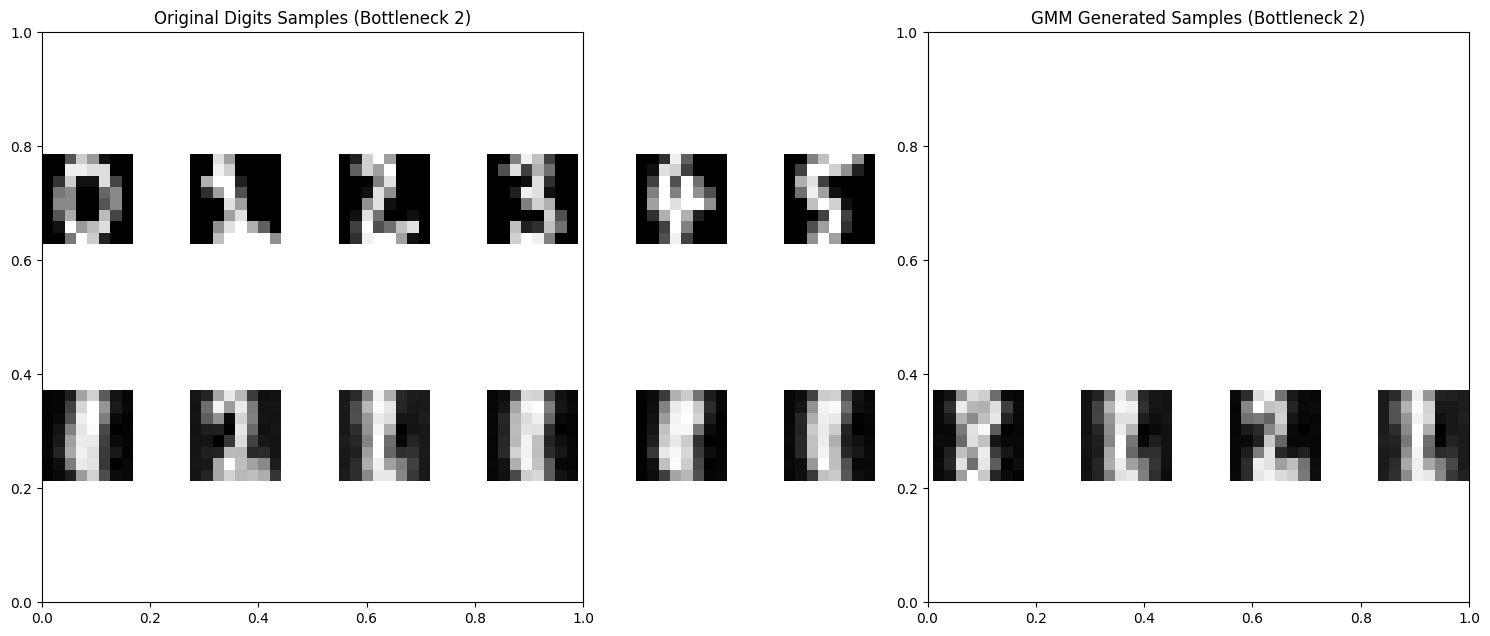


Synthetic Data Class Distribution (Bottleneck 2):
Digit 0: 10.4%
Digit 1: 9.5%
Digit 2: 9.0%
Digit 3: 9.9%
Digit 4: 9.7%
Digit 5: 6.1%
Digit 6: 8.5%
Digit 7: 12.5%
Digit 8: 13.9%
Digit 9: 10.5%

Analyzing GMM for bottleneck size 4


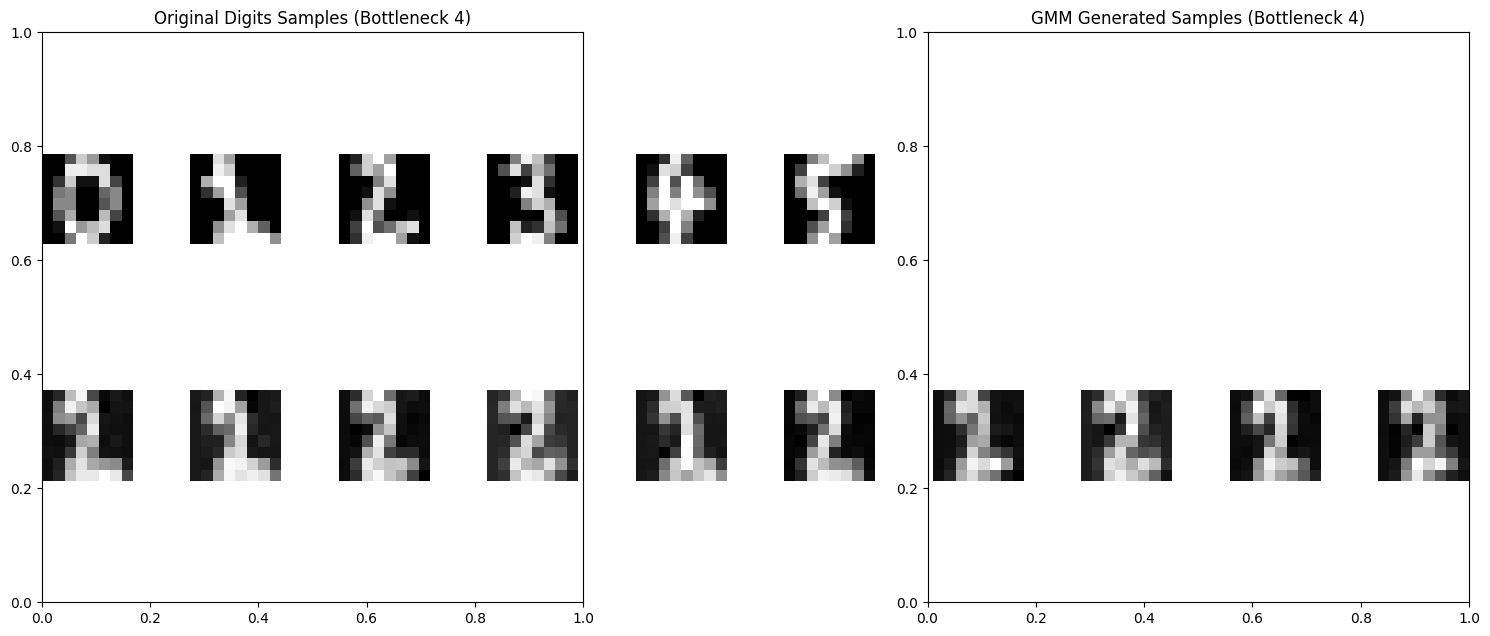


Synthetic Data Class Distribution (Bottleneck 4):
Digit 0: 10.4%
Digit 1: 7.6%
Digit 2: 10.9%
Digit 3: 9.8%
Digit 4: 8.2%
Digit 5: 7.6%
Digit 6: 11.4%
Digit 7: 11.1%
Digit 8: 10.5%
Digit 9: 12.5%

Analyzing GMM for bottleneck size 8


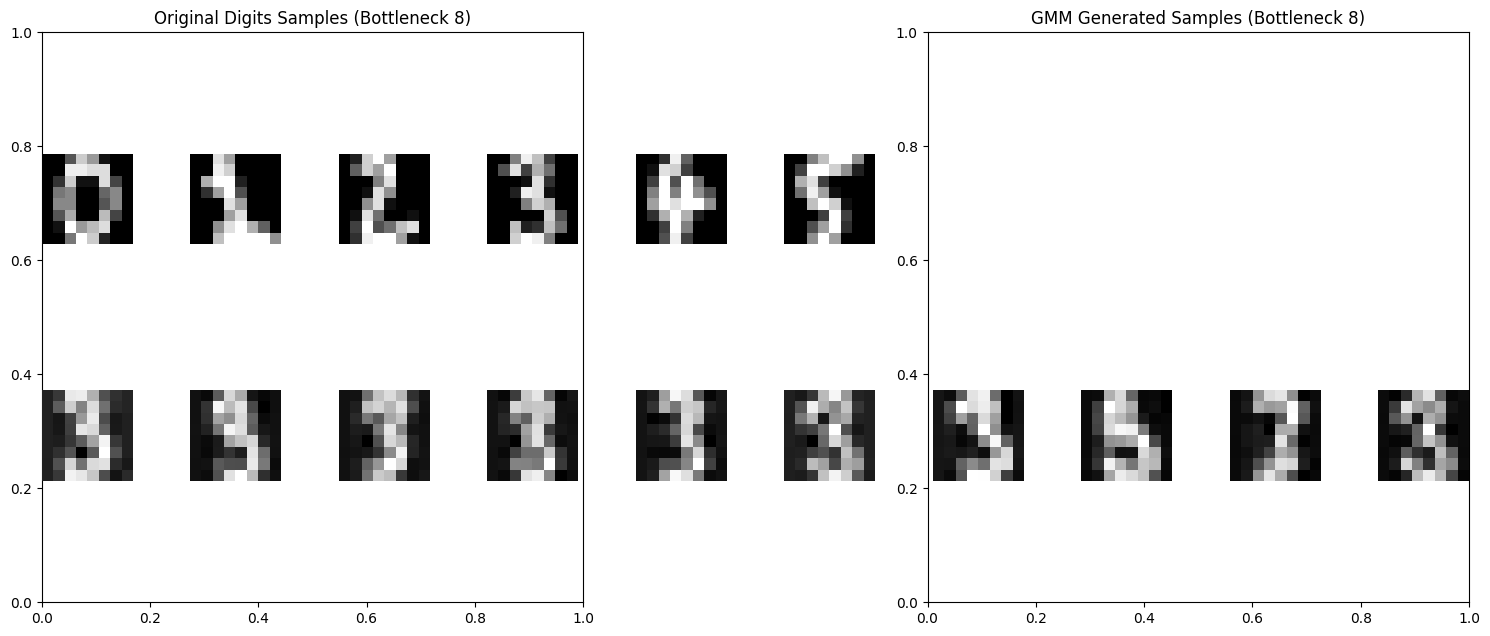


Synthetic Data Class Distribution (Bottleneck 8):
Digit 0: 8.7%
Digit 1: 5.3%
Digit 2: 9.8%
Digit 3: 8.6%
Digit 4: 9.1%
Digit 5: 9.2%
Digit 6: 10.7%
Digit 7: 13.4%
Digit 8: 13.2%
Digit 9: 12.0%


In [98]:
# Run analysis for each bottleneck size
for size in [2, 4, 8]:
    model = results[size]['model']
    print(f"\nAnalyzing GMM for bottleneck size {size}")
    synthetic_digits, synthetic_pred = analyze_digit_gmm(
        model, X_train, X_test, y_train, y_test, size)


<div style="color: green; font-weight: bold">Comment</div>
The sample solution  aims for balanced synthetic class distributions with GMM, regardless of bottleneck size. Your results show class imbalances, particularly for digits 1 and 5. Consider further tuning GMM components or adding latent space regularization to ensure more uniform class generation.
